<a href="https://colab.research.google.com/github/austinbennysmith/CMIP6/blob/main/NAO_Basic_NotNormalized.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Things this code does:
* **Plots the NAO spatial pattern and PC time series using SVD-based PCA**
* **Plots a smoothed NAO index time series based on the PCs**
* **Starts doing Probability Angular Momentum Analysis, based on Arin Nelson's PhD thesis**

Current weighting method:
* Multiply each data point by the square root of the cosine of its latitude before doing the SVD
* Dividing by the weights when plotting U but NOT when getting the Principal Components from VT. Does this make sense? I don't think it would make sense to divide by the weights for VT since it depends only on time. [This code](http://indico.ictp.it/event/a09161/session/11/contribution/7/material/0/0.pdf) uses the same method I use for weighting before the SVD computation and then dividing for plotting the left singular vectors, but they don't show time series so I'm not sure based on this site.

In [ ]:
!pip install fsspec
!pip install netCDF4
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
!pip install eofs
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
import numpy as np
from numpy import linalg as LA
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
from eofs.xarray import Eof
from nc_time_axis import NetCDFTimeConverter, CalendarDateTime
import cftime
from scipy import stats

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

from sklearn.preprocessing import StandardScaler

In [ ]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv') 
df.head()

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


activity_id institution_id  ... dcpp_init_year   version
0  AerChemMIP        AS-RCEC  ...            NaN  20200310
1  AerChemMIP            BCC  ...            NaN  20190718
2  AerChemMIP            BCC  ...            NaN  20191127
3  AerChemMIP            BCC  ...            NaN  20190809
4  AerChemMIP            BCC  ...            NaN  20191127

[5 rows x 11 columns]

In [ ]:
from datetime import date, timedelta
import netCDF4 as nc
psl_ssp585 = df.query("variable_id == 'psl' & experiment_id == 'ssp585' & institution_id == 'NCAR' & source_id == 'CESM2'")
# psl_ssp585 = df.query("variable_id == 'psl' & experiment_id == 'ssp585' & table_id == 'Amon' & source_id == 'EC-Earth3'")
for i in range(len(psl_ssp585)):
  print(i)

0
1
2


In [ ]:
# The following code just prints the number of ensemble members for each model for reference
ssp = df.query("variable_id == 'psl' & experiment_id == 'ssp585' & table_id == 'Amon'")
unique_sources = []
for i in ssp['source_id']:
  if i not in unique_sources:
    unique_sources.append(i)
print(unique_sources)

for i in unique_sources:
  x = ssp.query("source_id =="+"'"+i+"'")
  print(str(len(x))+': '+i)

['TaiESM1', 'AWI-CM-1-1-MR', 'BCC-CSM2-MR', 'CAMS-CSM1-0', 'FGOALS-f3-L', 'FGOALS-g3', 'CanESM5-CanOE', 'CanESM5', 'IITM-ESM', 'CMCC-CM2-SR5', 'CNRM-CM6-1-HR', 'CNRM-CM6-1', 'CNRM-ESM2-1', 'ACCESS-CM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-HR', 'E3SM-1-1', 'EC-Earth3-Veg-LR', 'EC-Earth3-Veg', 'EC-Earth3', 'FIO-ESM-2-0', 'INM-CM4-8', 'INM-CM5-0', 'IPSL-CM6A-LR', 'KIOST-ESM', 'MIROC-ES2L', 'MIROC6', 'HadGEM3-GC31-LL', 'HadGEM3-GC31-MM', 'UKESM1-0-LL', 'MPI-ESM1-2-LR', 'MRI-ESM2-0', 'GISS-E2-1-G', 'CESM2-WACCM', 'CESM2', 'NorESM2-LM', 'NorESM2-MM', 'KACE-1-0-G', 'GFDL-CM4', 'GFDL-ESM4', 'NESM3', 'CIESM', 'MCM-UA-1-0']
1: TaiESM1
1: AWI-CM-1-1-MR
1: BCC-CSM2-MR
2: CAMS-CSM1-0
1: FGOALS-f3-L
4: FGOALS-g3
3: CanESM5-CanOE
50: CanESM5
1: IITM-ESM
1: CMCC-CM2-SR5
1: CNRM-CM6-1-HR
6: CNRM-CM6-1
5: CNRM-ESM2-1
3: ACCESS-CM2
10: ACCESS-ESM1-5
2: MPI-ESM1-2-HR
1: E3SM-1-1
3: EC-Earth3-Veg-LR
6: EC-Earth3-Veg
58: EC-Earth3
3: FIO-ESM-2-0
1: INM-CM4-8
1: INM-CM5-0
6: IPSL-CM6A-LR
1: KIOST-ESM
1: MIROC-ES2L


Singular Value Decomposition of the data for the SSP5-8.5 scenario:

In [ ]:
# Accessing the file, getting it to just the lats and lons I want:
zstore = psl_ssp585.zstore.values[0]
mapper = fsspec.get_mapper(zstore)
ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Make decode_times=True to convert dates to datetime objects?? The problem is, Colab doesn't seem to like my installation of nc-time-axis. I could try a Jupyter Binder, or keep Googling to try to solve this.
psl = ds.psl.sel(lat=slice(20,80))
psl = psl.where((ds.lon >= 270) | (ds.lon <= 40), drop=True)
lat = ds.lat.sel(lat=slice(20,80))
lon = ds.lon.where((ds.lon >= 270) | (ds.lon <= 40), drop=True) # Not sure exactly what drop means, but I think it doesn't matter


# Useful stackexchange post: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
# Dividing up the data by season:
def is_djf(month):
  return (month>=12) | ((month>=1) & (month<=2))
def is_mam(month):
  return (month>=3) & (month<=5)
def is_jja(month):
  return (month>=6) & (month<=8)
def is_son(month):
  return (month>=9) & (month<=11)
psl_djf = psl.sel(time=is_djf(psl['time.month']))
psl_mam = psl.sel(time=is_mam(psl['time.month']))
psl_jja = psl.sel(time=is_jja(psl['time.month']))
psl_son = psl.sel(time=is_son(psl['time.month']))


psl_allseasons = {
    'DJF': psl_djf,
    'MAM': psl_mam,
    'JJA': psl_jja,
    'SON': psl_son
}
# Splitting it up by decade:
decades = np.arange(2010, 2110, 10)
decade_list = [] # I'll use decade_list for graphing.
for i in range(len(decades)):
  if i<(len(decades)-1):
    decade_list.append(str(decades[i])+'-'+str(decades[i+1]))
decade_list[0] = '2015-2020'

def in_decade(minyear, maxyear, year):
  return (year>=minyear) & (year<maxyear)
psl_FINAL = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}
for j in psl_allseasons.keys():
  for i in range(1, len(decades)):
    psl_FINAL[j].append(psl_allseasons[j].sel(time=in_decade(decades[i-1], decades[i], psl_allseasons[j]['time.year'])))

# I need to weight the data by the square root of the cosine of latitude. Right now I think it's working
psl_WEIGHTED = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}
weights = np.sqrt(np.cos(np.radians(psl_FINAL['JJA'][0].lat))) # Latitudes are the same for all of the sub-datasets, so I can define the weights according to latitude based on a randomly chosen sub-dataset outside of the for loop to save time
for season in psl_FINAL.keys():
  for i in range(len(psl_FINAL[season])): # Need to do this for each decade within the seasonal dictionary entries
    tlength = len(psl_FINAL[season][i].time) # Need to have the correct time length in order to make the arrays below.
    latlength = len(psl_FINAL[season][i].lat)
    lonlength = len(psl_FINAL[season][i].lon)
    print(tlength)
    psl_weighted = np.ones((tlength, latlength, lonlength)) # This will be filled up with the weighted latitudes.
    loaded_psl = psl_FINAL[season][i].values #Loading the data before the for loop drastically speeds up the program
    for j in range(latlength):
      psl_weighted[:, j, :] = loaded_psl[:, j, :]*float(weights[j])
    psl_WEIGHTED[season].append(psl_weighted)

# Defining dictionaries for U, s, VT, and Sigma:
Udict = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}
sdict = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}
VTdict = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}
Sigmadict = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}
estimatedict = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}

for key in psl_FINAL.keys():
  for i in range(9):
    print(i)
    tlength = len(psl_FINAL[key][i].time) # The psl_WEIGHTED dictionary does not contain DataArray objects, so I can't just get the time from that.
    psl2d = np.reshape(psl_WEIGHTED[key][i], (tlength, latlength*lonlength)) # This is the only line in the for loop I changed when adding in the weighting
    psl2d = np.matrix.transpose(psl2d)
    Unow, snow, VTnow = LA.svd(psl2d, full_matrices=False)
    Sigmanow = np.diag(snow)
    estimatenow = Unow[:, :1] @ Sigmanow[0:1, :1] @ VTnow[:1, :]
    estimatenow = np.matrix.transpose(estimatenow) #Doing this so that I can later reshape the approximation matrix to have dimensionality (time, lat, lon), for consistency since this is how the climate NetCDF files are typically structured.
    Udict[key].append(Unow)
    sdict[key].append(snow)
    VTdict[key].append(VTnow)
    estimatedict[key].append(estimatenow)

Plotting the PCs of each decade individually:

In [ ]:
def svectors(season):
  mins = []
  maxes = []
  for i in range(len(Udict[season])):
    U1 = Udict[season][i][:, 0]
    U12d = U1.reshape((latlength, lonlength))
    U12d=np.matmul(np.diag(weights**-1), U12d)
    for j in U12d:
      mins.append(min(j))
      maxes.append(max(j))
  # print(min(mins), max(maxes))
  minimum = min(mins)
  maximum=max(maxes)
  
  cmap1=plt.cm.RdYlBu_r
  levels = np.linspace(minimum, maximum, 30)
  # levels = np.linspace(-0.015700901684942033, -0.015352819022413573, 10)
  fig = plt.figure()
  fig.set_figheight(20)
  fig.set_figwidth(20)
  for i in range(9):
    ax1 = fig.add_subplot(3, 3, i+1)
    ax1.plot(psl_FINAL[season][i].time, VTdict[season][i][0], 'o') #The first index here tells where in the list of VT matrices to go from (i.e. which decade), the second index tells which eigen time series to graph
    ax1.set_title(season+' First Right Singular Vector (time series)')
    ax1.set_ylabel('Value')
    ax1.set_xlabel('Time')
  plt.show()
  fig2, axarr = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
  axlist = axarr.flatten() # Helpful code: https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
  for i in range(9):
    U1 = Udict[season][i][:, 0] # Each column of U is a "basis eigenpattern" that represents a direction of variability in the dataset. I'm just looking at the first basis eigenpattern, which is by FAR the most important one (can be demonstrated by plotting the singular values)
    U12d = U1.reshape((latlength, lonlength)) # Getting it reshaped so that I can graph it as lat, lon
    U12d=np.matmul(np.diag(weights**-1), U12d)
    cs=axlist[i].contourf(lon, lat, U12d,levels,
                  transform=ccrs.PlateCarree(),
                  cmap=cmap1)
    axlist[i].coastlines()
    axlist[i].set_extent([-90, 40, 20, 80]) # longitude latitude extent
    cbar = fig.colorbar(cs, ax=axlist[i], orientation='horizontal') # color map
    cbar.ax.set_xticklabels([round(i, 5) for i in levels], rotation=40)
    cbar.set_label('Value')
    axlist[i].set_title(season+' First Left Singular Vector '+decade_list[i])
  plt.show()
for key in psl_FINAL.keys():
  svectors(key)

Mapping the change in the NAO pattern over time (the difference between each decade and the 2015-2020 decade is mapped)

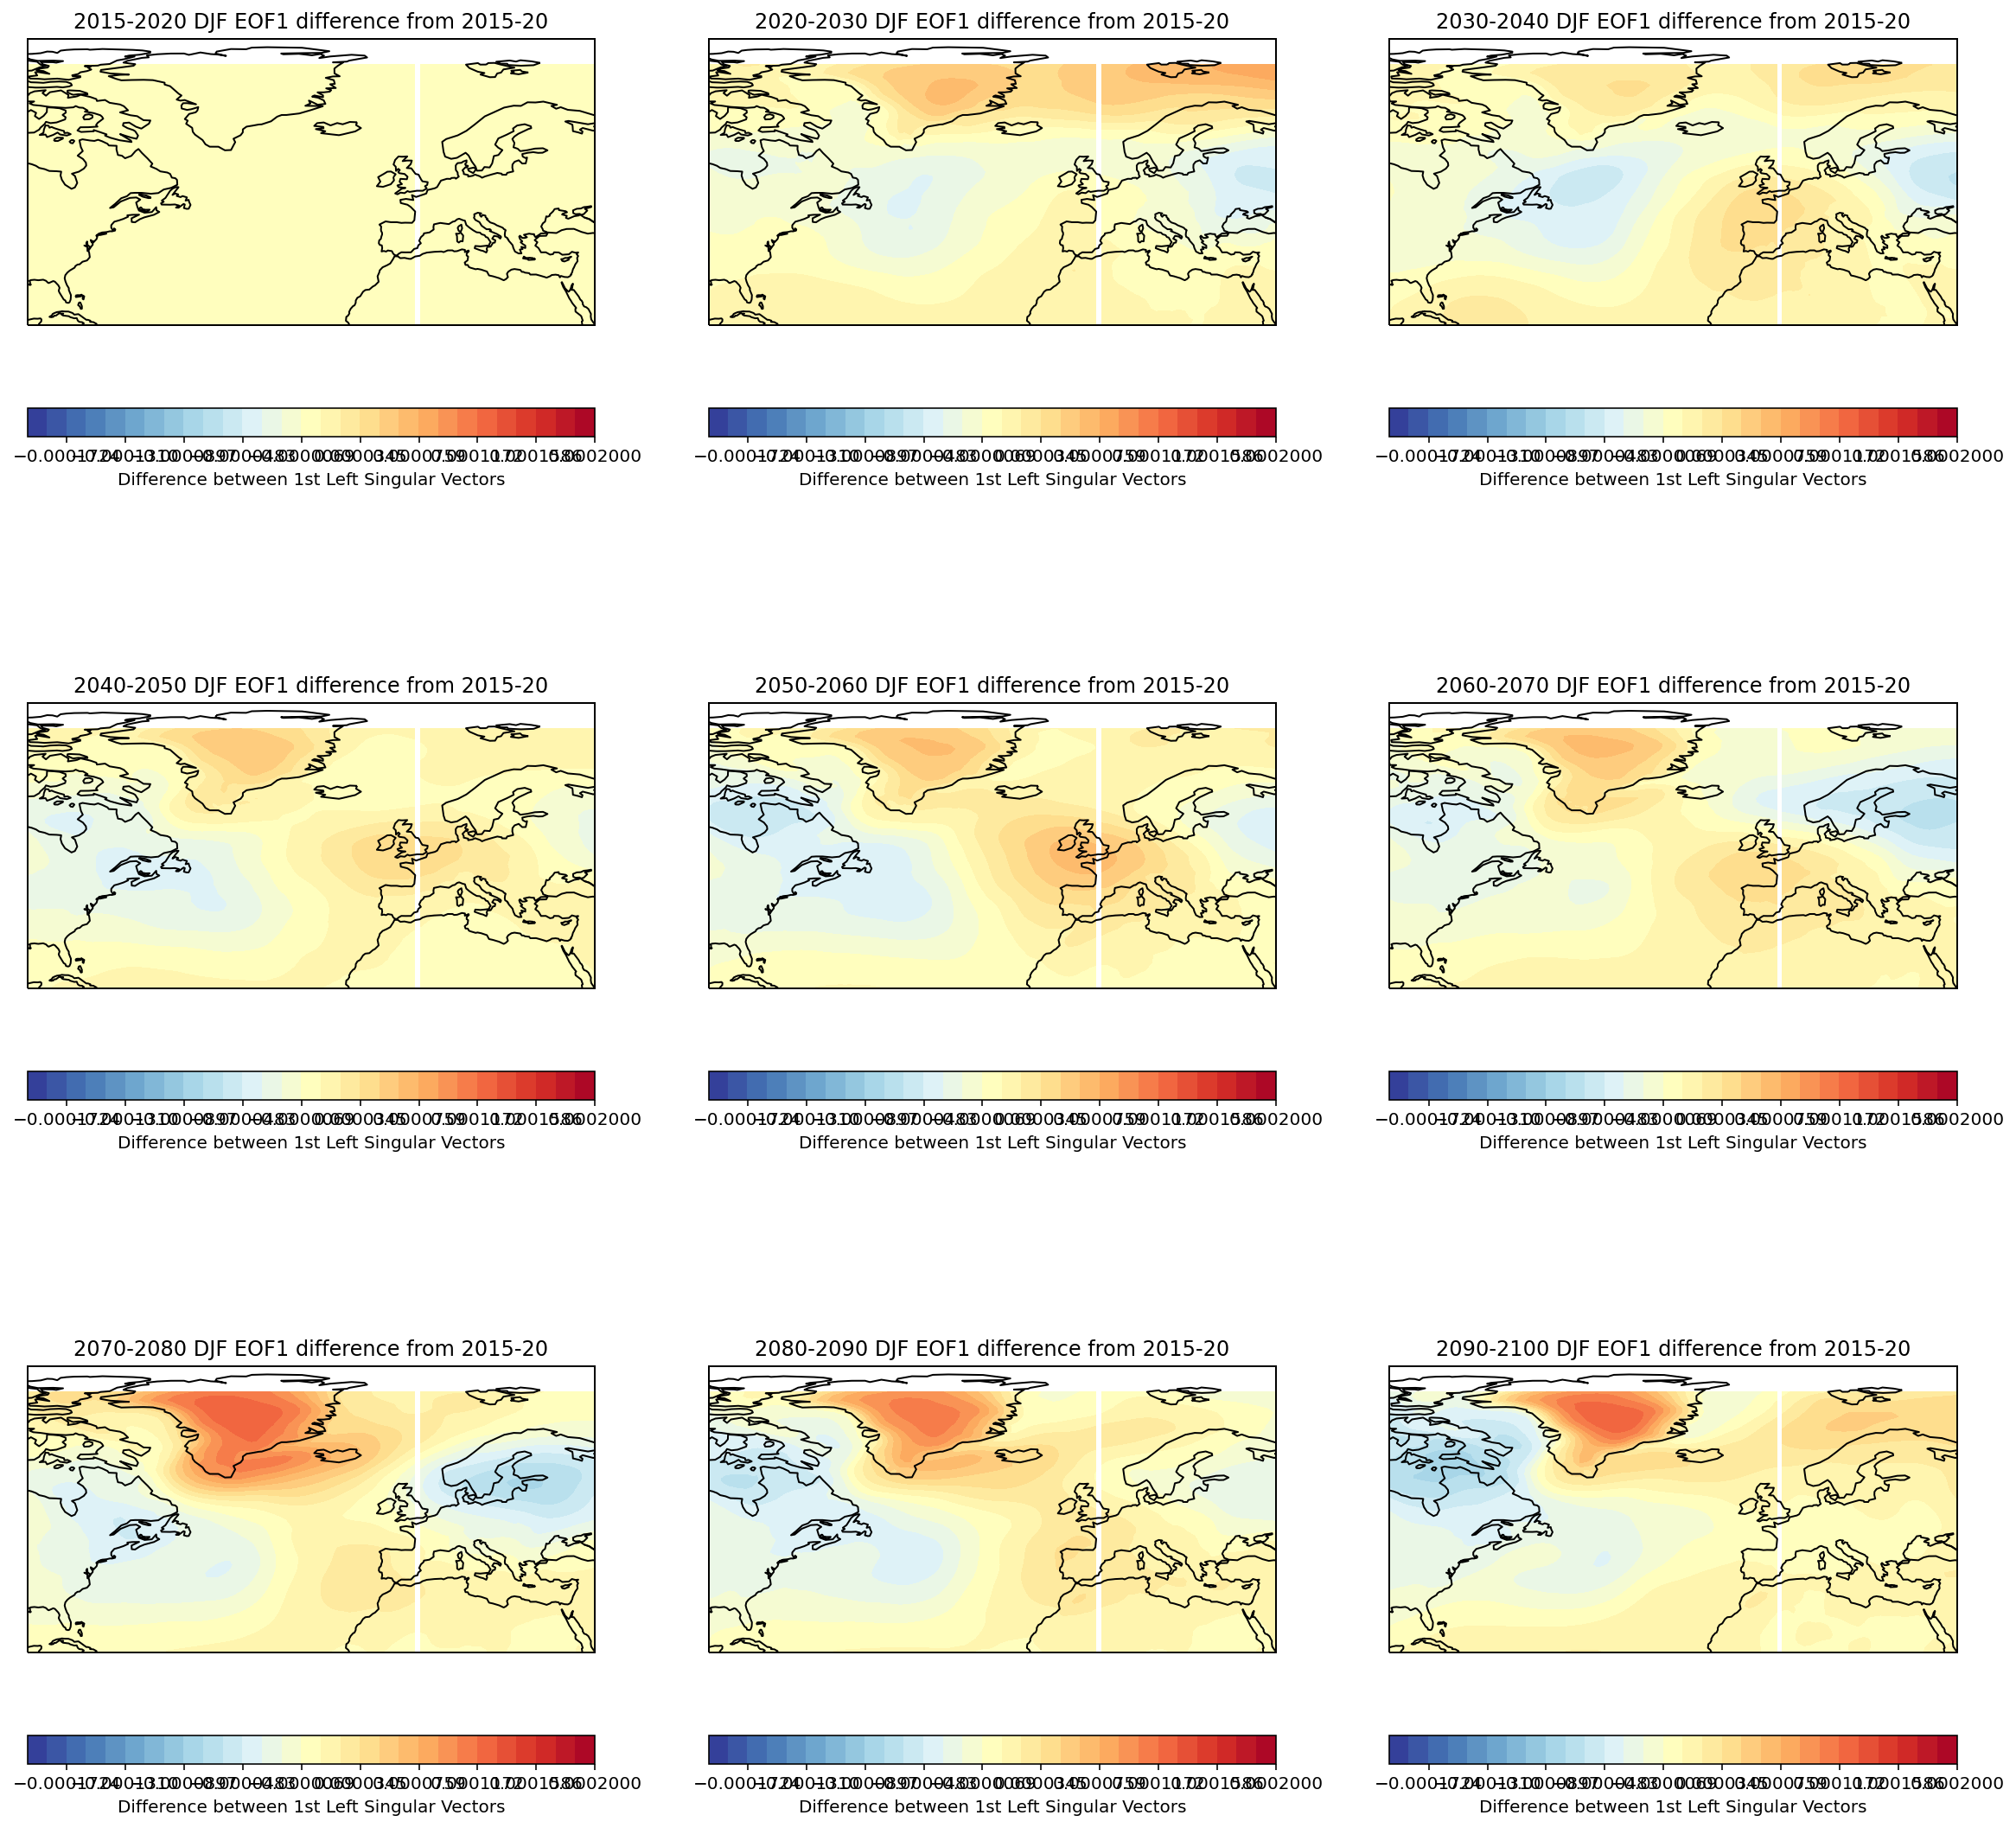

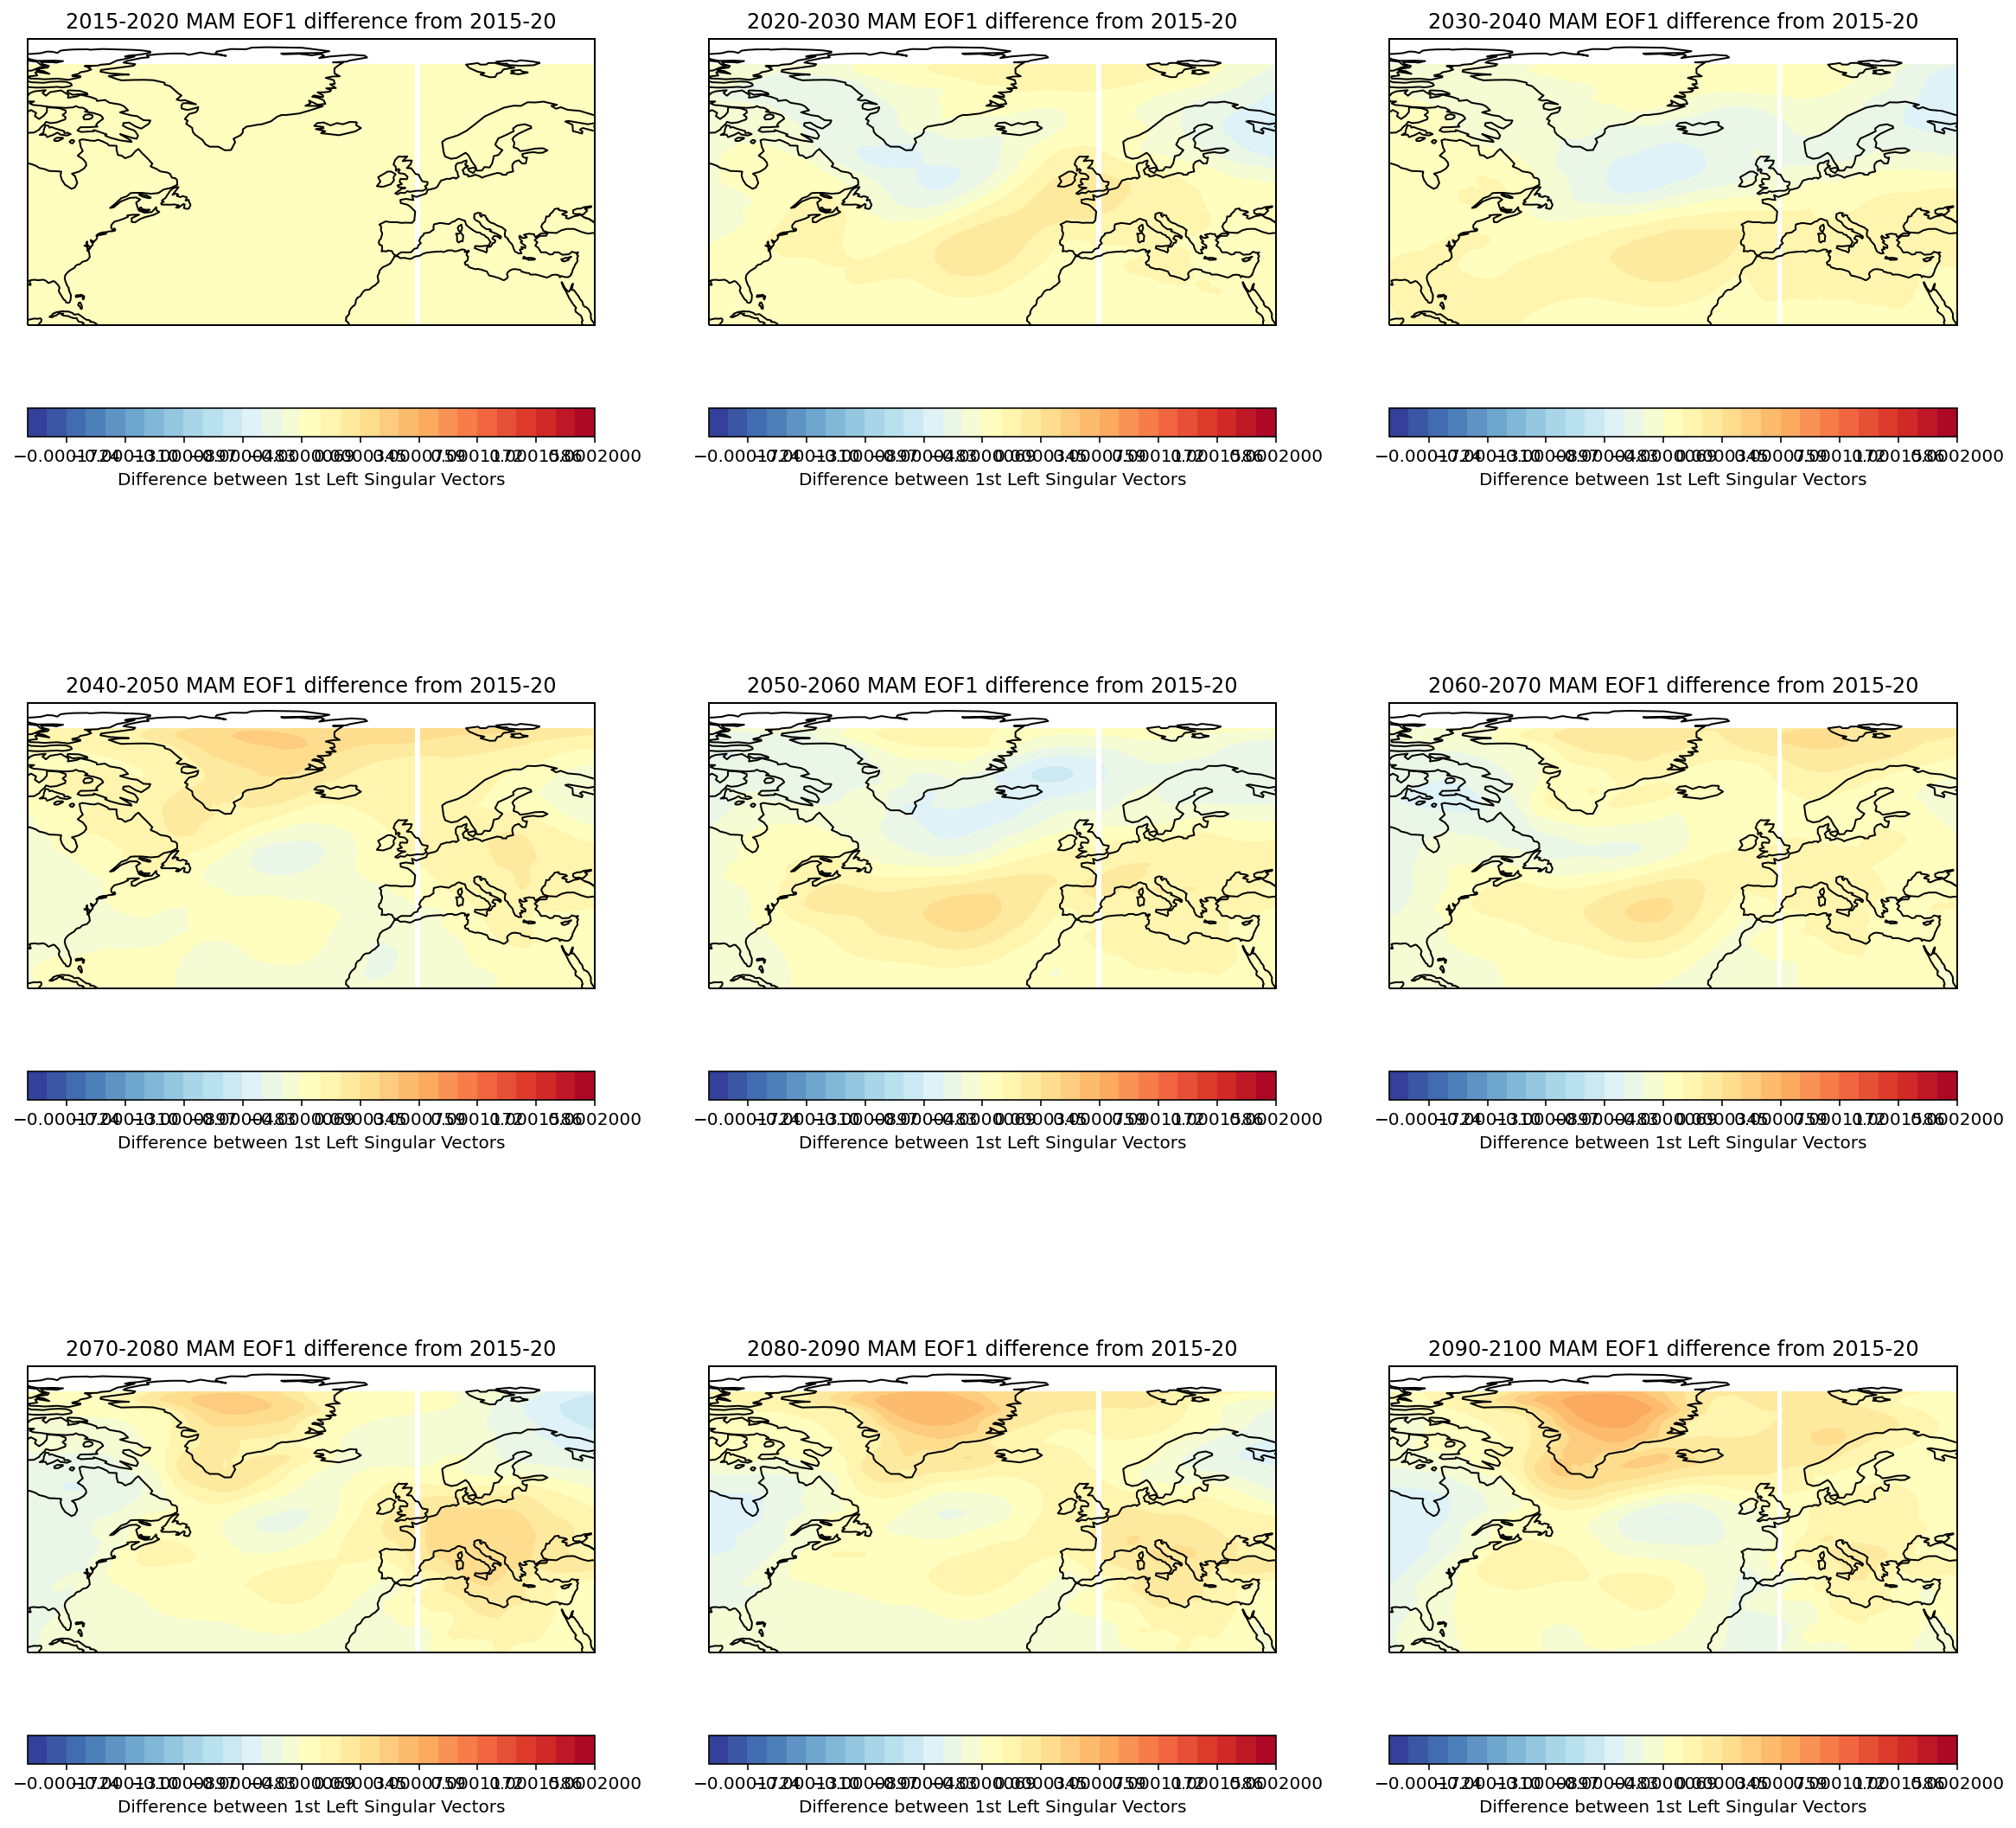

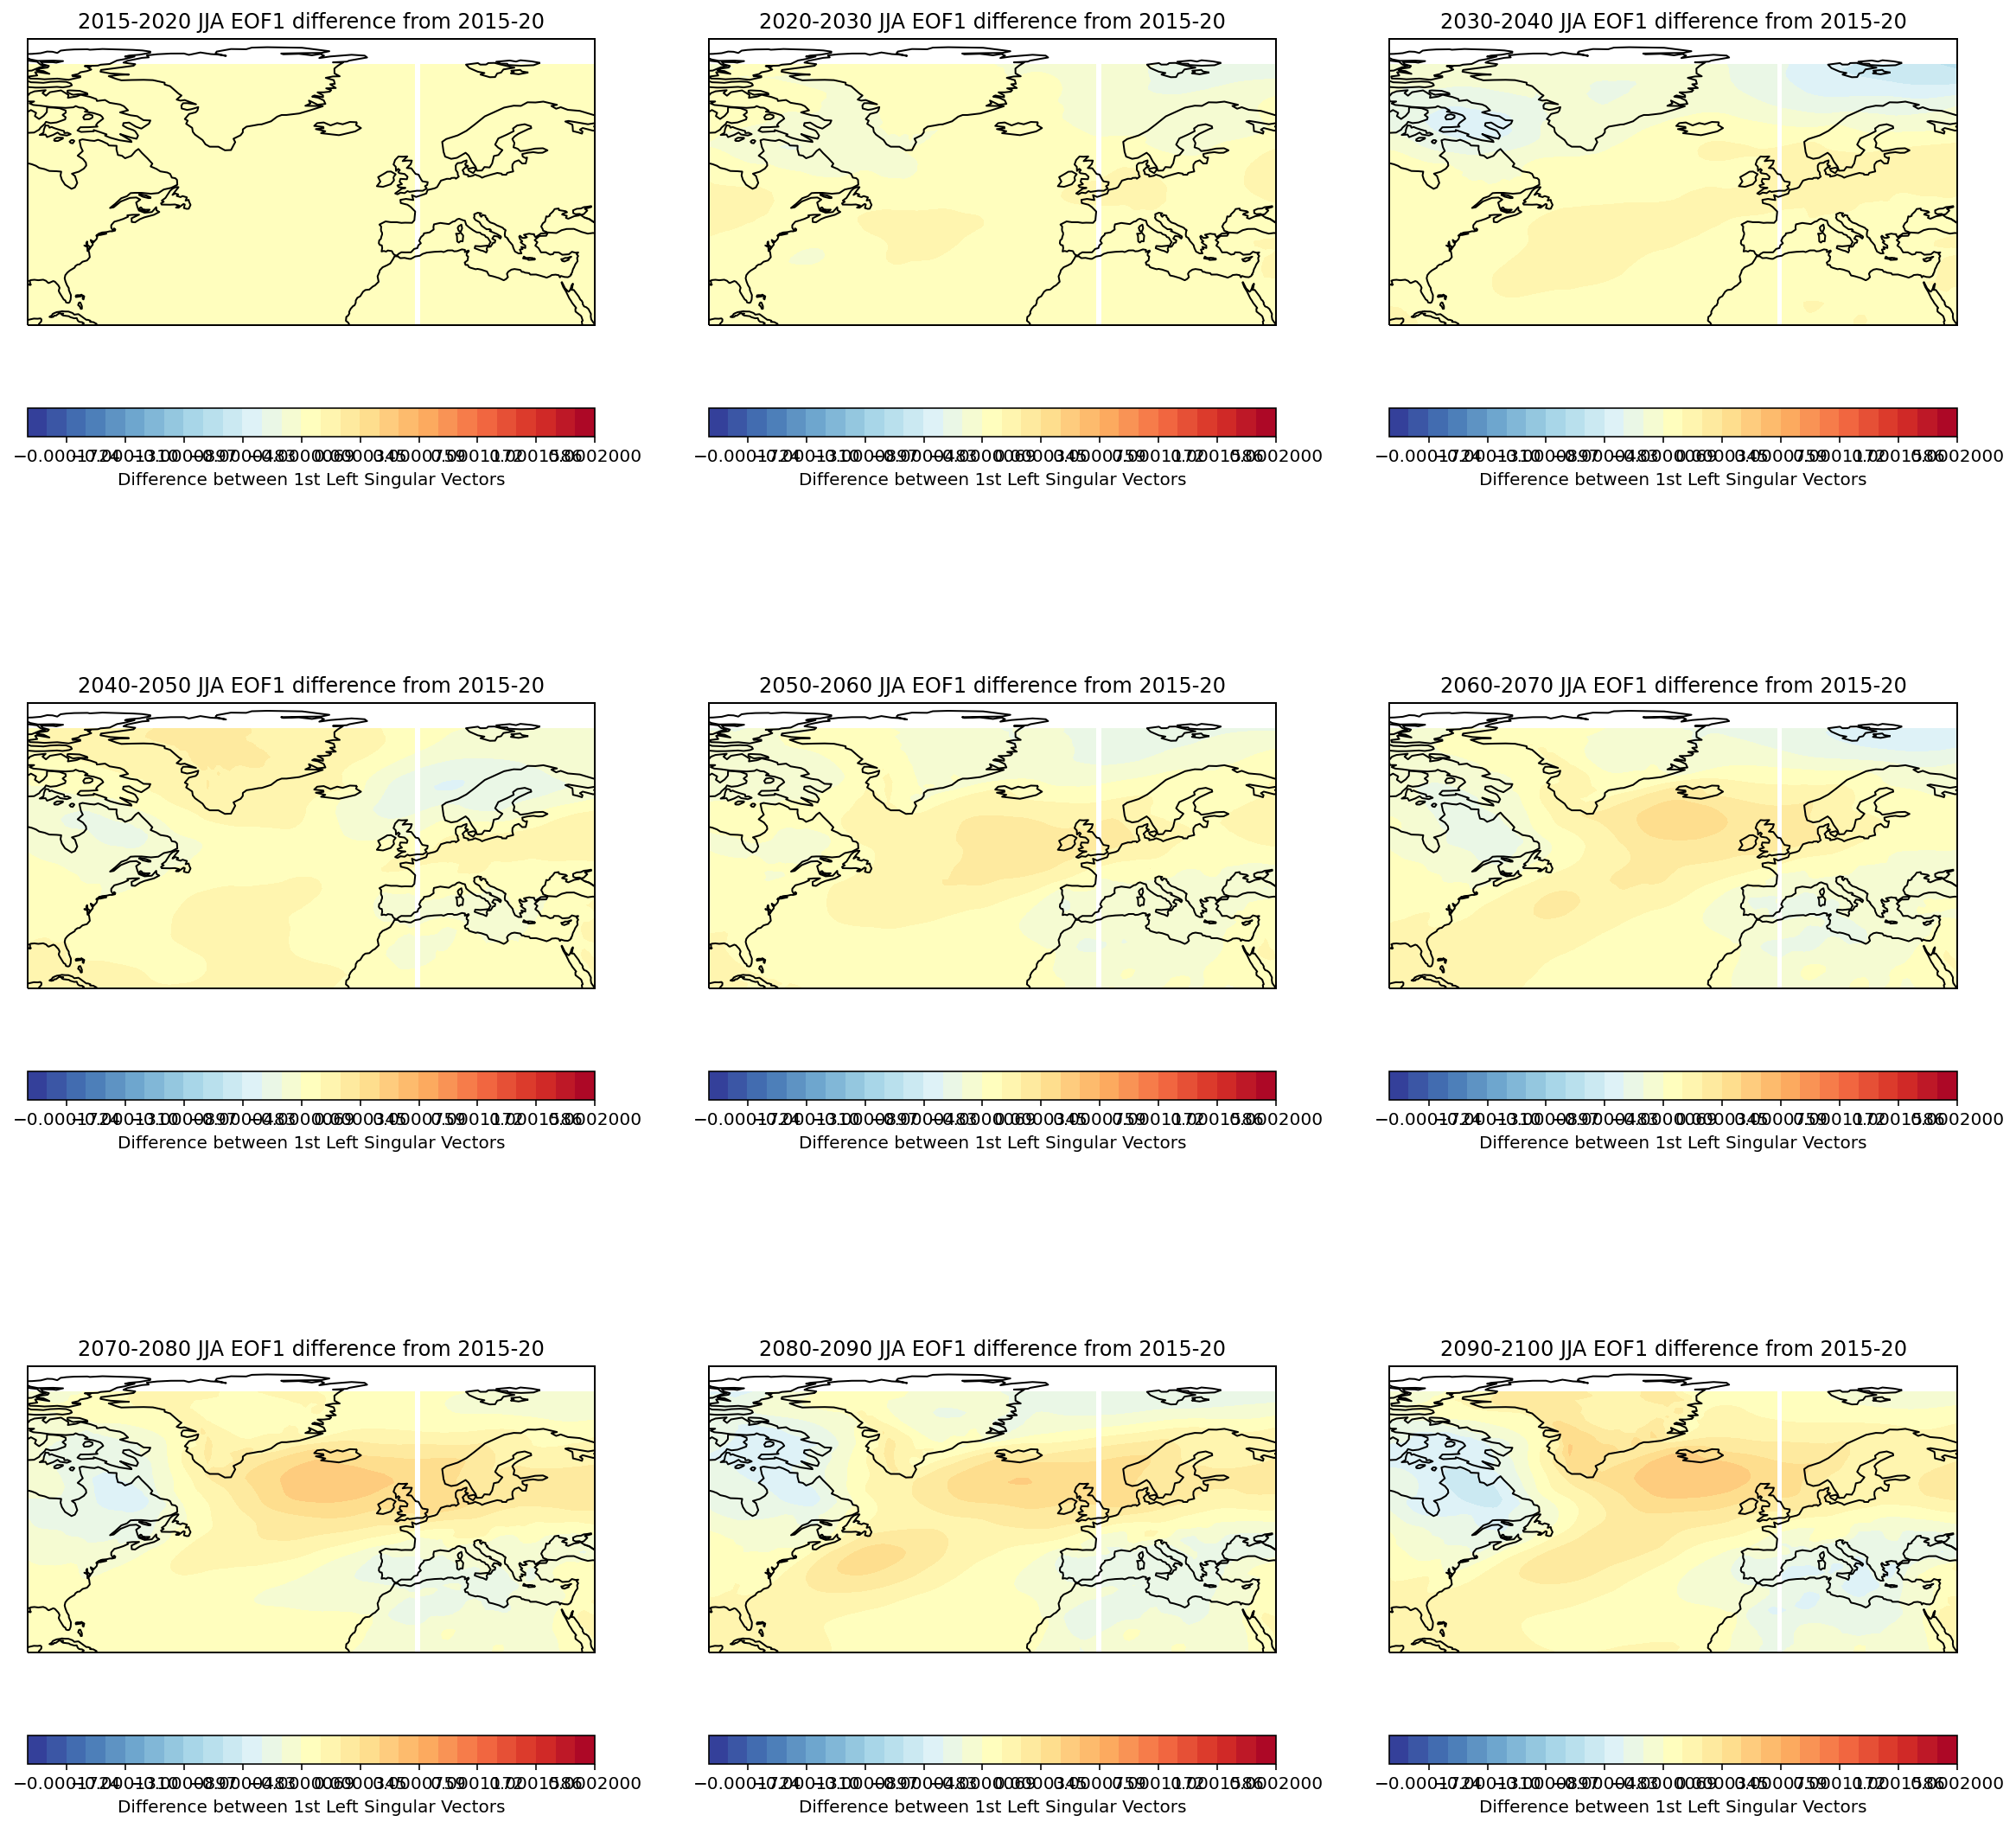

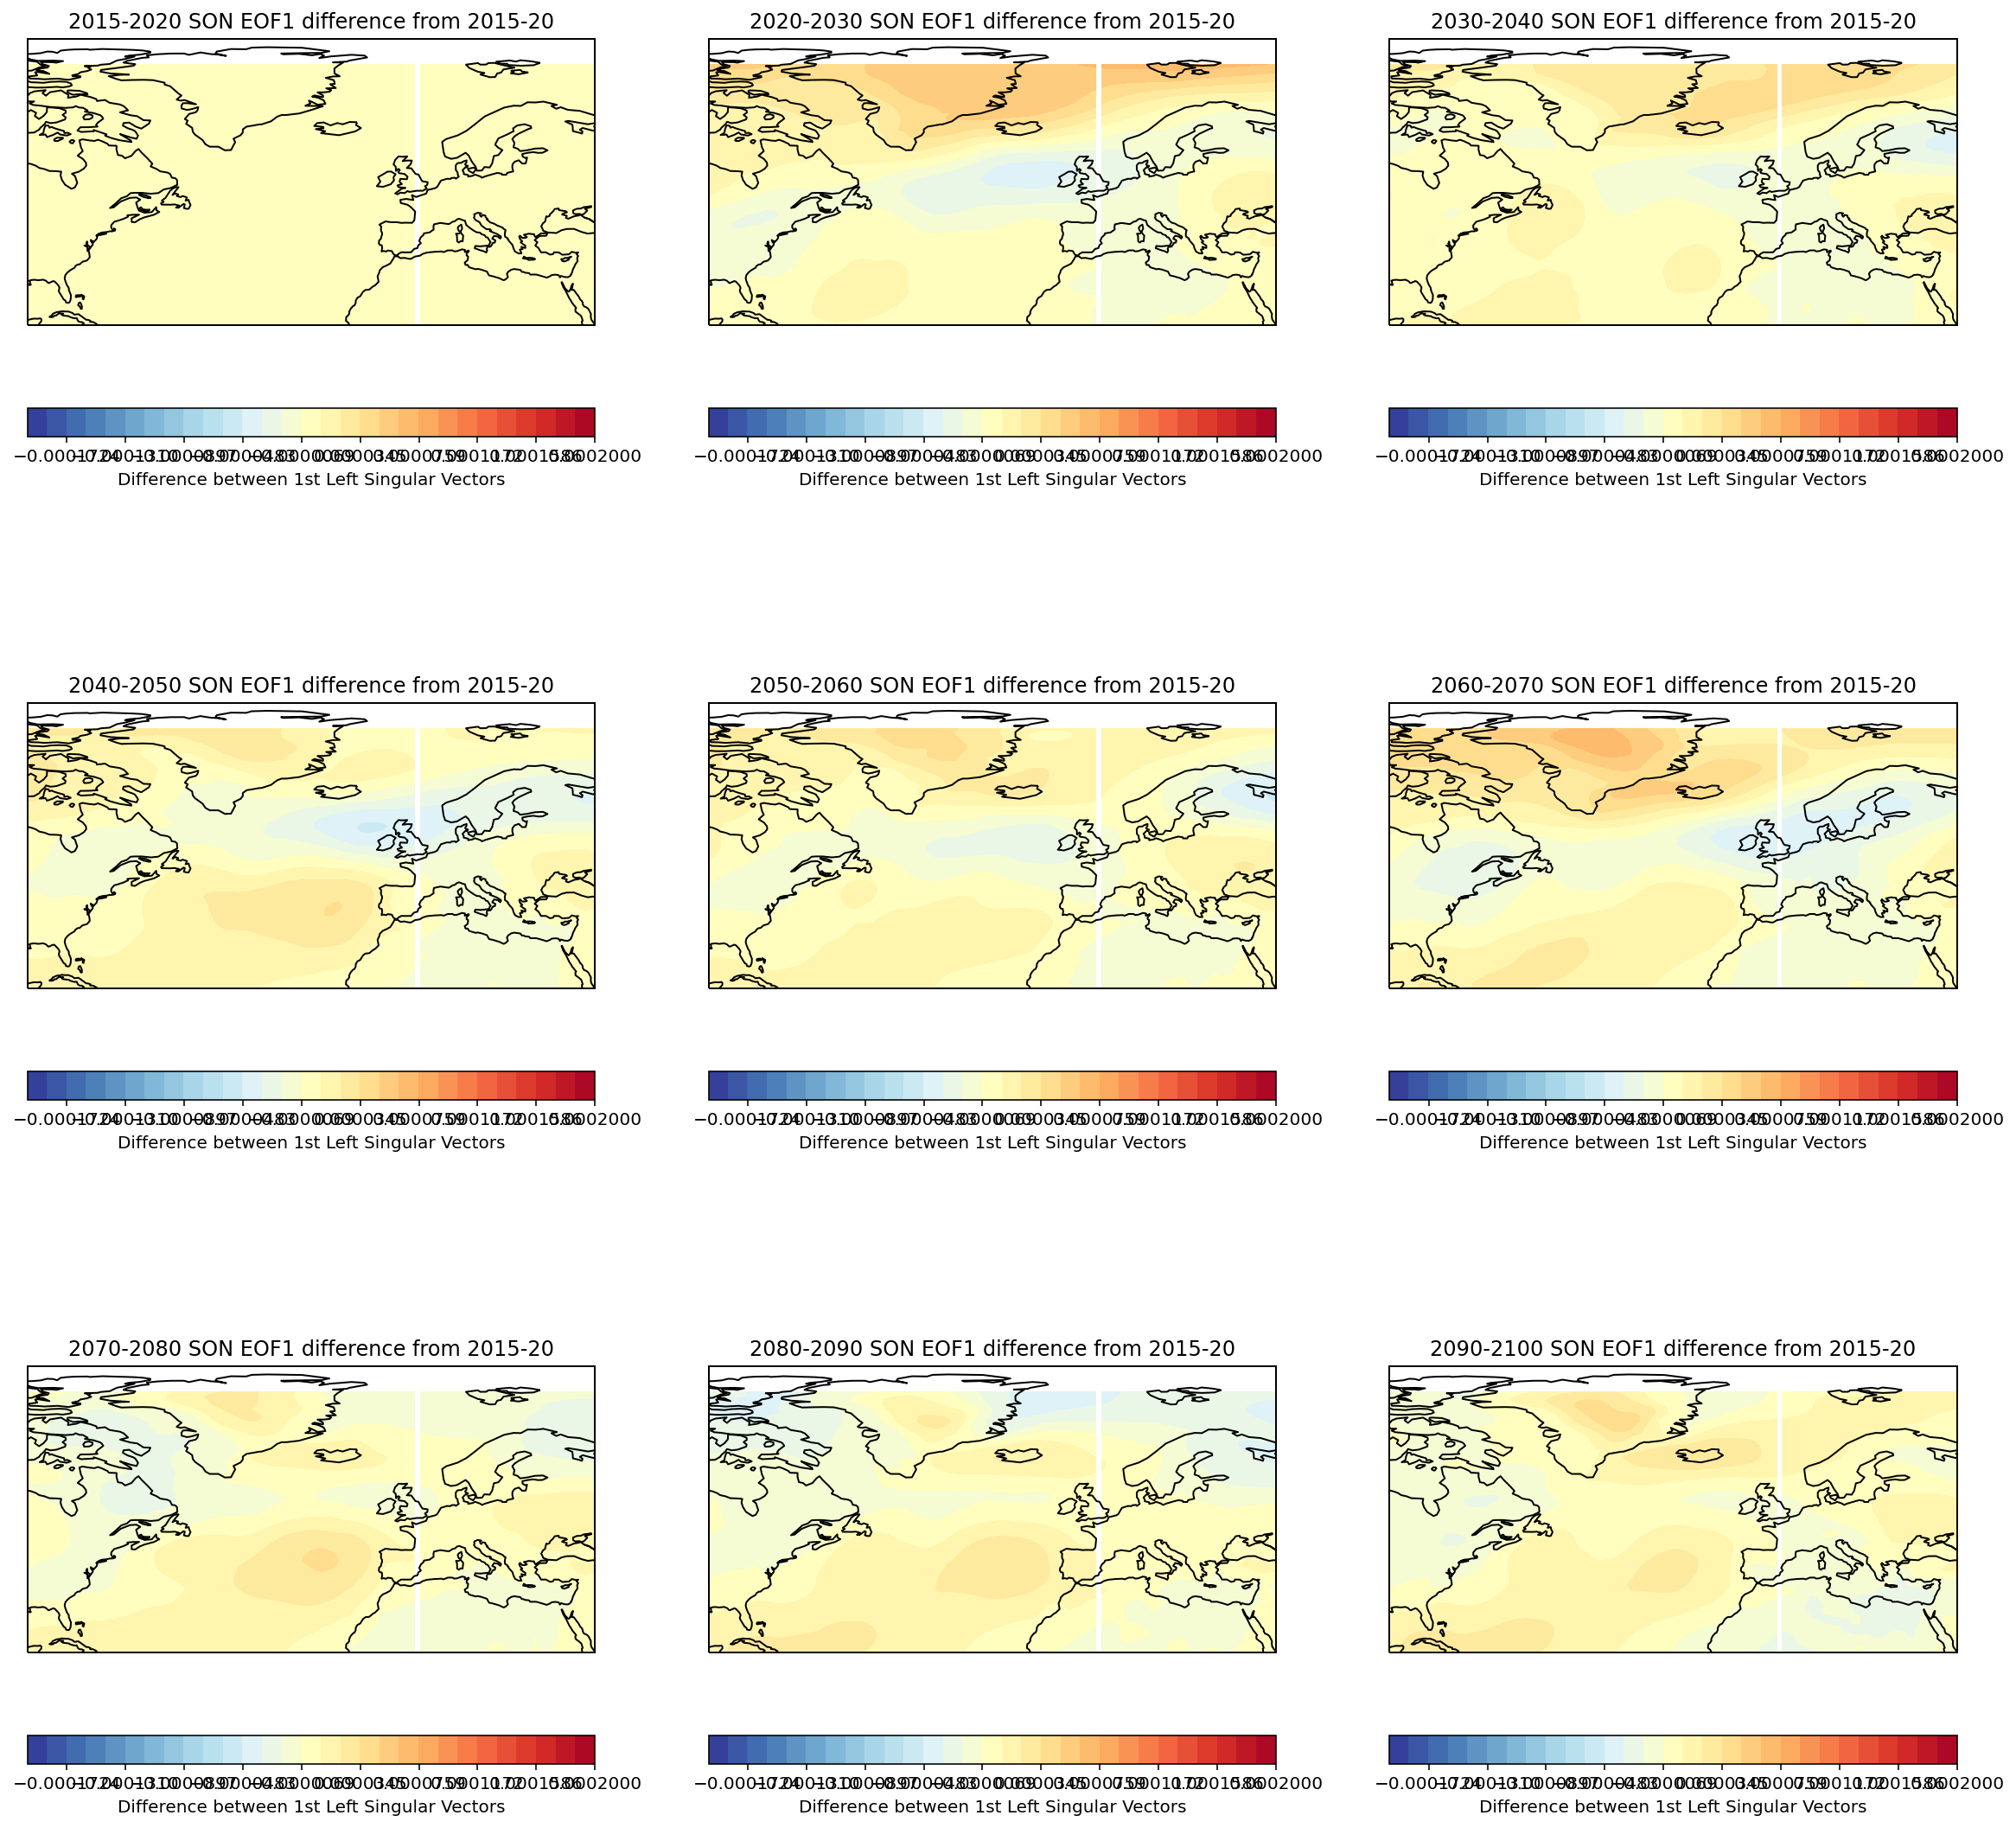

In [ ]:
def changes(season):
  Ustart = Udict[season][0][:,  0]
  Ustart2d = Ustart.reshape((latlength, lonlength))
  Ustart2d=np.matmul(np.diag(weights**-1), Ustart2d)
  # diffLevels = np.linspace(-4.7268346e-05, 4.6583824e-05, 10)
  diffLevels=np.linspace(-2e-4, 2e-4, 30)
  fig, axarr = plt.subplots(nrows=3, ncols=3, figsize=(20, 20), subplot_kw={'projection': ccrs.PlateCarree()})
  axlist = axarr.flatten()
  cmap1=plt.cm.RdYlBu_r
  for i in range(len(Udict[season])):
    U1 = Udict[season][i][:, 0] # Each column of U is a "basis eigenpattern" that represents a direction of variability in the dataset. I'm just looking at the first basis eigenpattern, which is by FAR the most important one (can be demonstrated by plotting the singular values)
    U12d = U1.reshape((latlength, lonlength)) # Getting it reshaped so that I can graph it as lat, lon
    U12d=np.matmul(np.diag(weights**-1), U12d)
    cs=axlist[i].contourf(lon, lat, Ustart2d-U12d,diffLevels,
                  transform=ccrs.PlateCarree(),
                  cmap=cmap1)
    axlist[i].coastlines()
    axlist[i].set_extent([-90, 40, 20, 80]) # longitude latitude extent
    cbar = fig.colorbar(cs, ax=axlist[i], orientation='horizontal') # color map
    cbar.set_label('Difference between 1st Left Singular Vectors')
    axlist[i].set_title(decade_list[i]+' '+season+' EOF1 difference from 2015-20')
  plt.show()
for key in psl_FINAL.keys():
  changes(key)

In [ ]:
## I'm not sure why the principal component time series are different in the first decade than everywhere else
full_timeSeries = np.array([])
for i in range(9):
  full_timeSeries = np.append(full_timeSeries, VTdict['DJF'][i][0])
plt.plot(full_timeSeries)

## NAO Index 21st century trend:
Some of the statistics is based on Arin Nelson's PhD thesis (see Figure 3.1 there)

The following cell is doing SVD:

In [ ]:
# weights = np.sqrt(np.cos(np.radians(psl_FINAL['JJA'][0].lat))) # Latitudes are the same for all of the sub-datasets, so I can define the weights according to latitude based on a randomly chosen sub-dataset outside of the for loop to save time
# for season in psl_FINAL.keys():
#   for i in range(len(psl_FINAL[season])): # Need to do this for each decade within the seasonal dictionary entries
#     tlength = len(psl_FINAL[season][i].time) # Need to have the correct time length in order to make the arrays below.
#     psl_weighted = np.ones((tlength, 64, 105)) # This will be filled up with the weighted latitudes.
#     loaded_psl = psl_FINAL[season][i].values #Loading the data before the for loop drastically speeds up the program
#     for j in range(64):
#       psl_weighted[:, j, :] = loaded_psl[:, j, :]*float(weights[j])
#     psl_WEIGHTED[season].append(psl_weighted)

century_trends = {
    'DJF': {},
    'JJA': {},
    'MAM': {},
    'SON': {}
}
for key in psl_FINAL.keys():
  print(key)
  tlength = len(psl_allseasons[key].time) # The psl_WEIGHTED dictionary does not contain DataArray objects, so I can't just get the time from that.
  psl2d = np.reshape(psl_allseasons[key].values, (tlength, latlength*lonlength)) # This is the only line in the for loop I changed when adding in the weighting
  psl2d = np.matrix.transpose(psl2d)
  Unow, snow, VTnow = LA.svd(psl2d, full_matrices=False)
  century_trends[key]['U'] = Unow
  century_trends[key]['s'] = snow
  century_trends[key]['VT'] = VTnow

Getting the anomalies and putting them in an eigenpatterns dictionary:

In [ ]:
eigenpatterns = {}
SEASONS = ['DJF', 'MAM', 'JJA', 'SON']
# Moving average code from https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w
for singVal in range(2): # the range here decides for how many singular values the patterns are normalized and smoothed
  eigenpatterns['singVal '+str(singVal)]={
      'anomalies': {},
      'smoothed': {}
  }
  for season in SEASONS:
    eigenpatterns['singVal '+str(singVal)]['anomalies'][season] = century_trends[season]['VT'][singVal]-np.mean(century_trends[season]['VT'][singVal])
    nao_smoothed = moving_average(eigenpatterns['singVal '+str(singVal)]['anomalies'][season], 30) # Doing the moving average for 30 points because each season is 3 months per year - so this is a 10 year running mean
    eigenpatterns['singVal '+str(singVal)]['smoothed'][season] = nao_smoothed

Plotting the resulting NAO Index based on the right singular vectors, as well as a smoothed plot made using a decadal moving average:

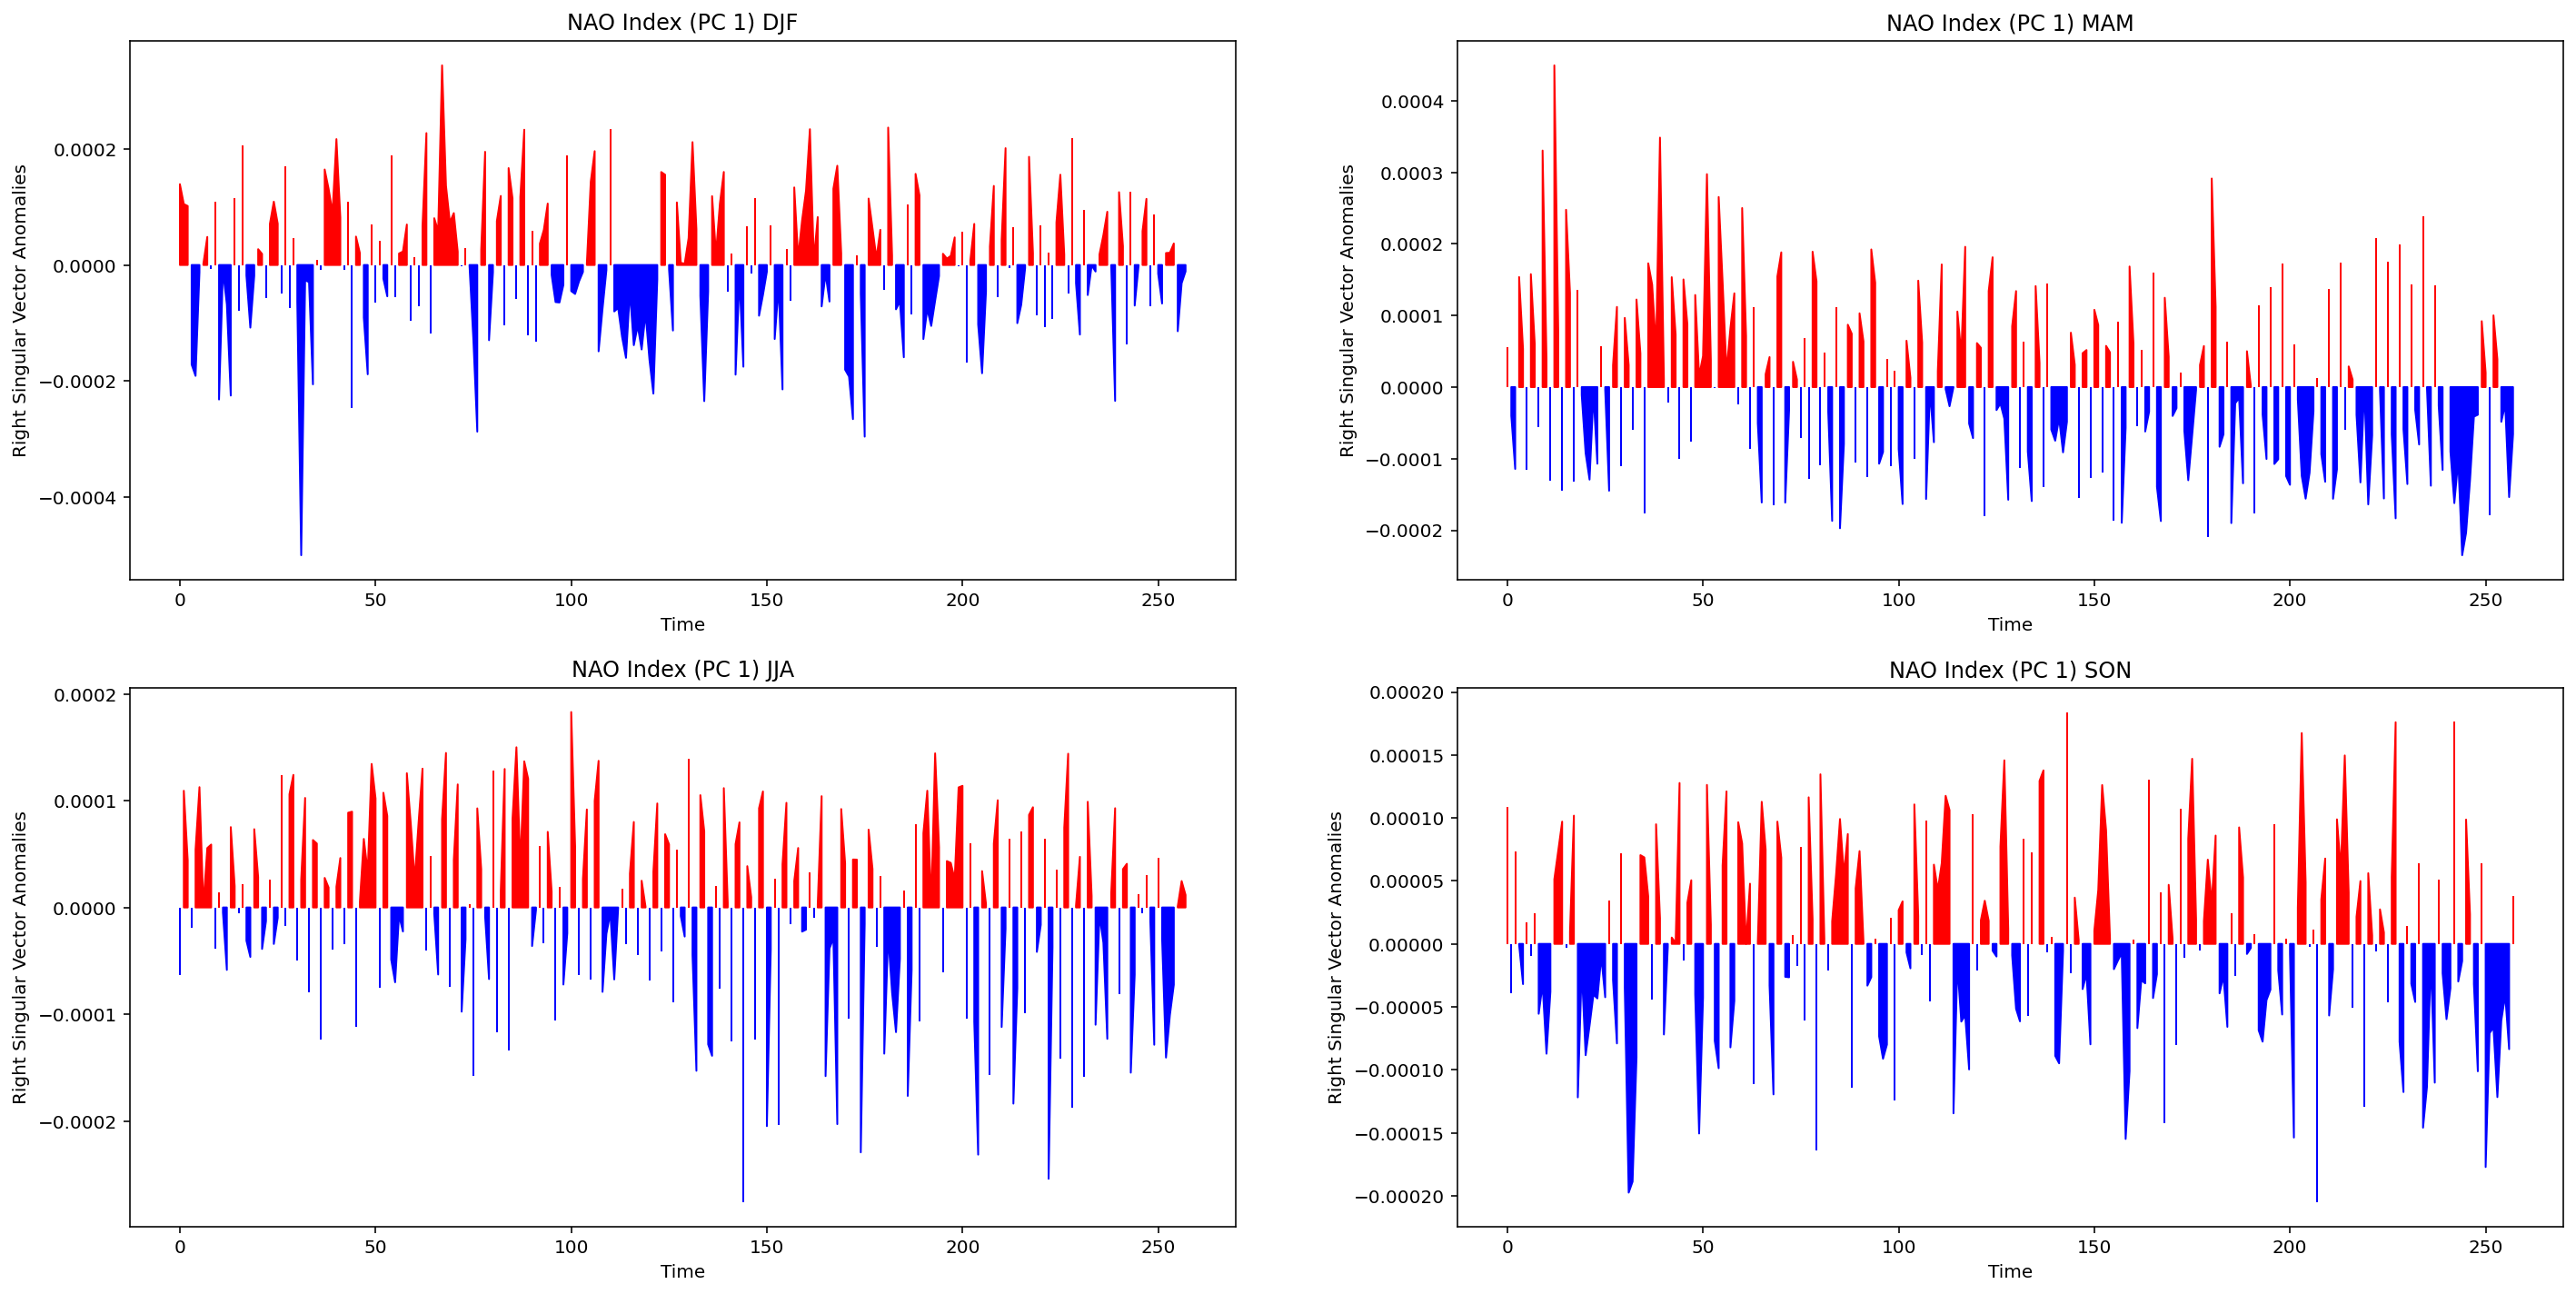

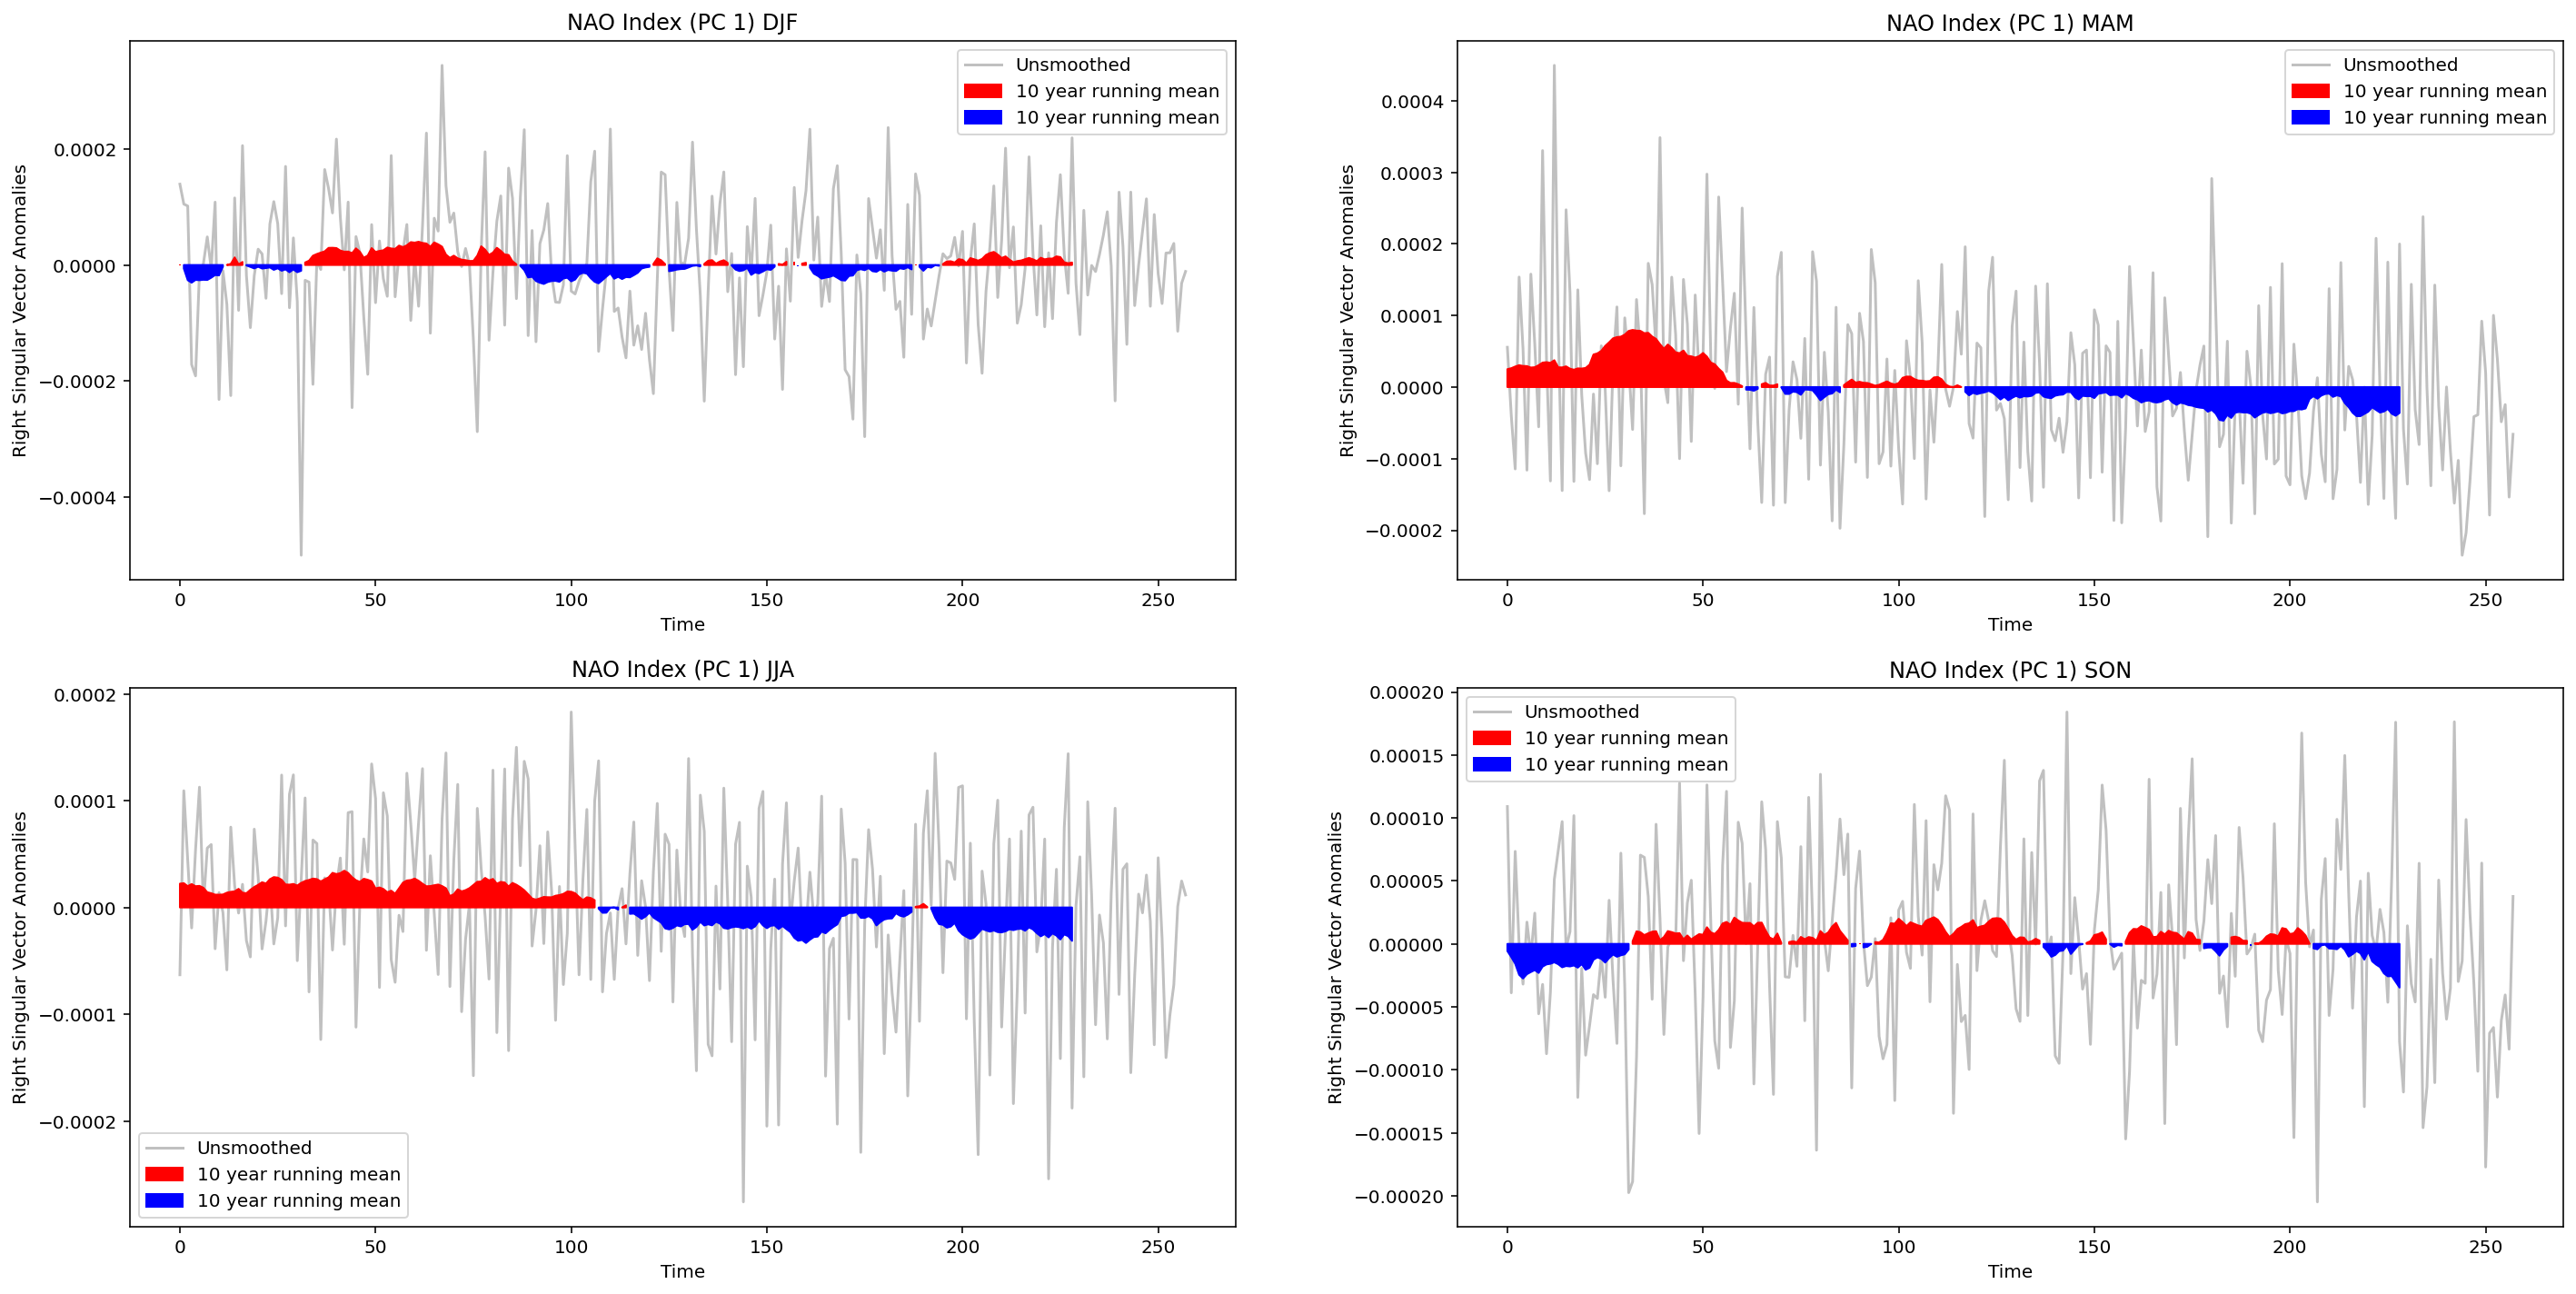

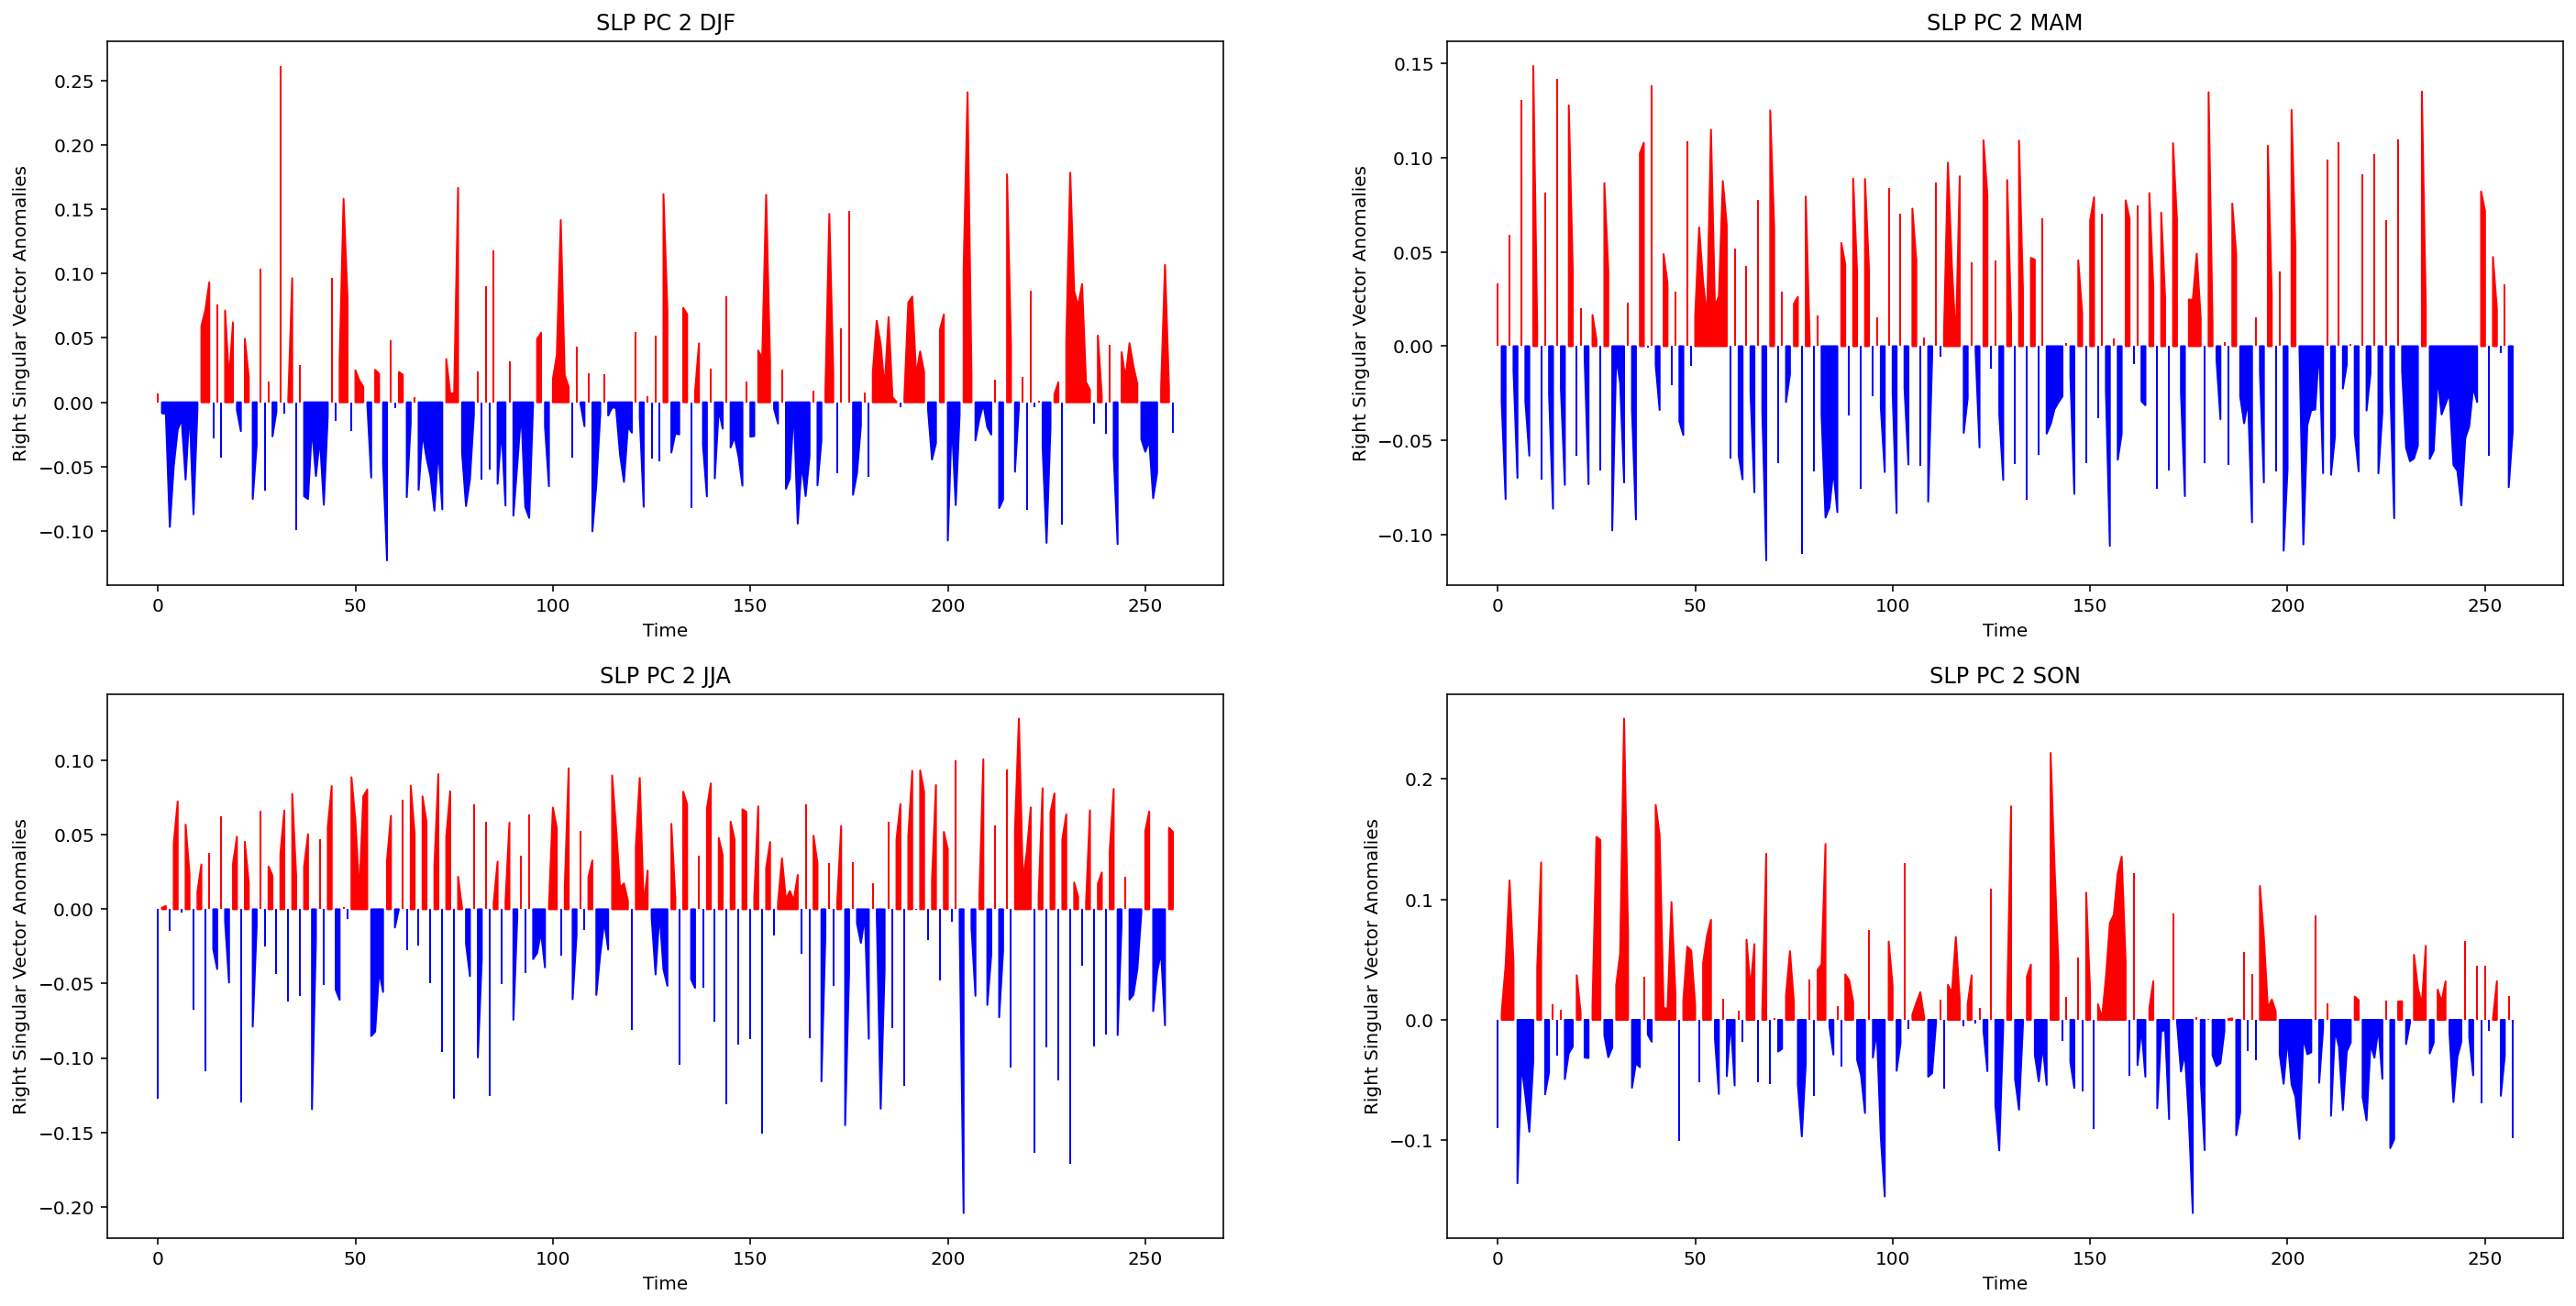

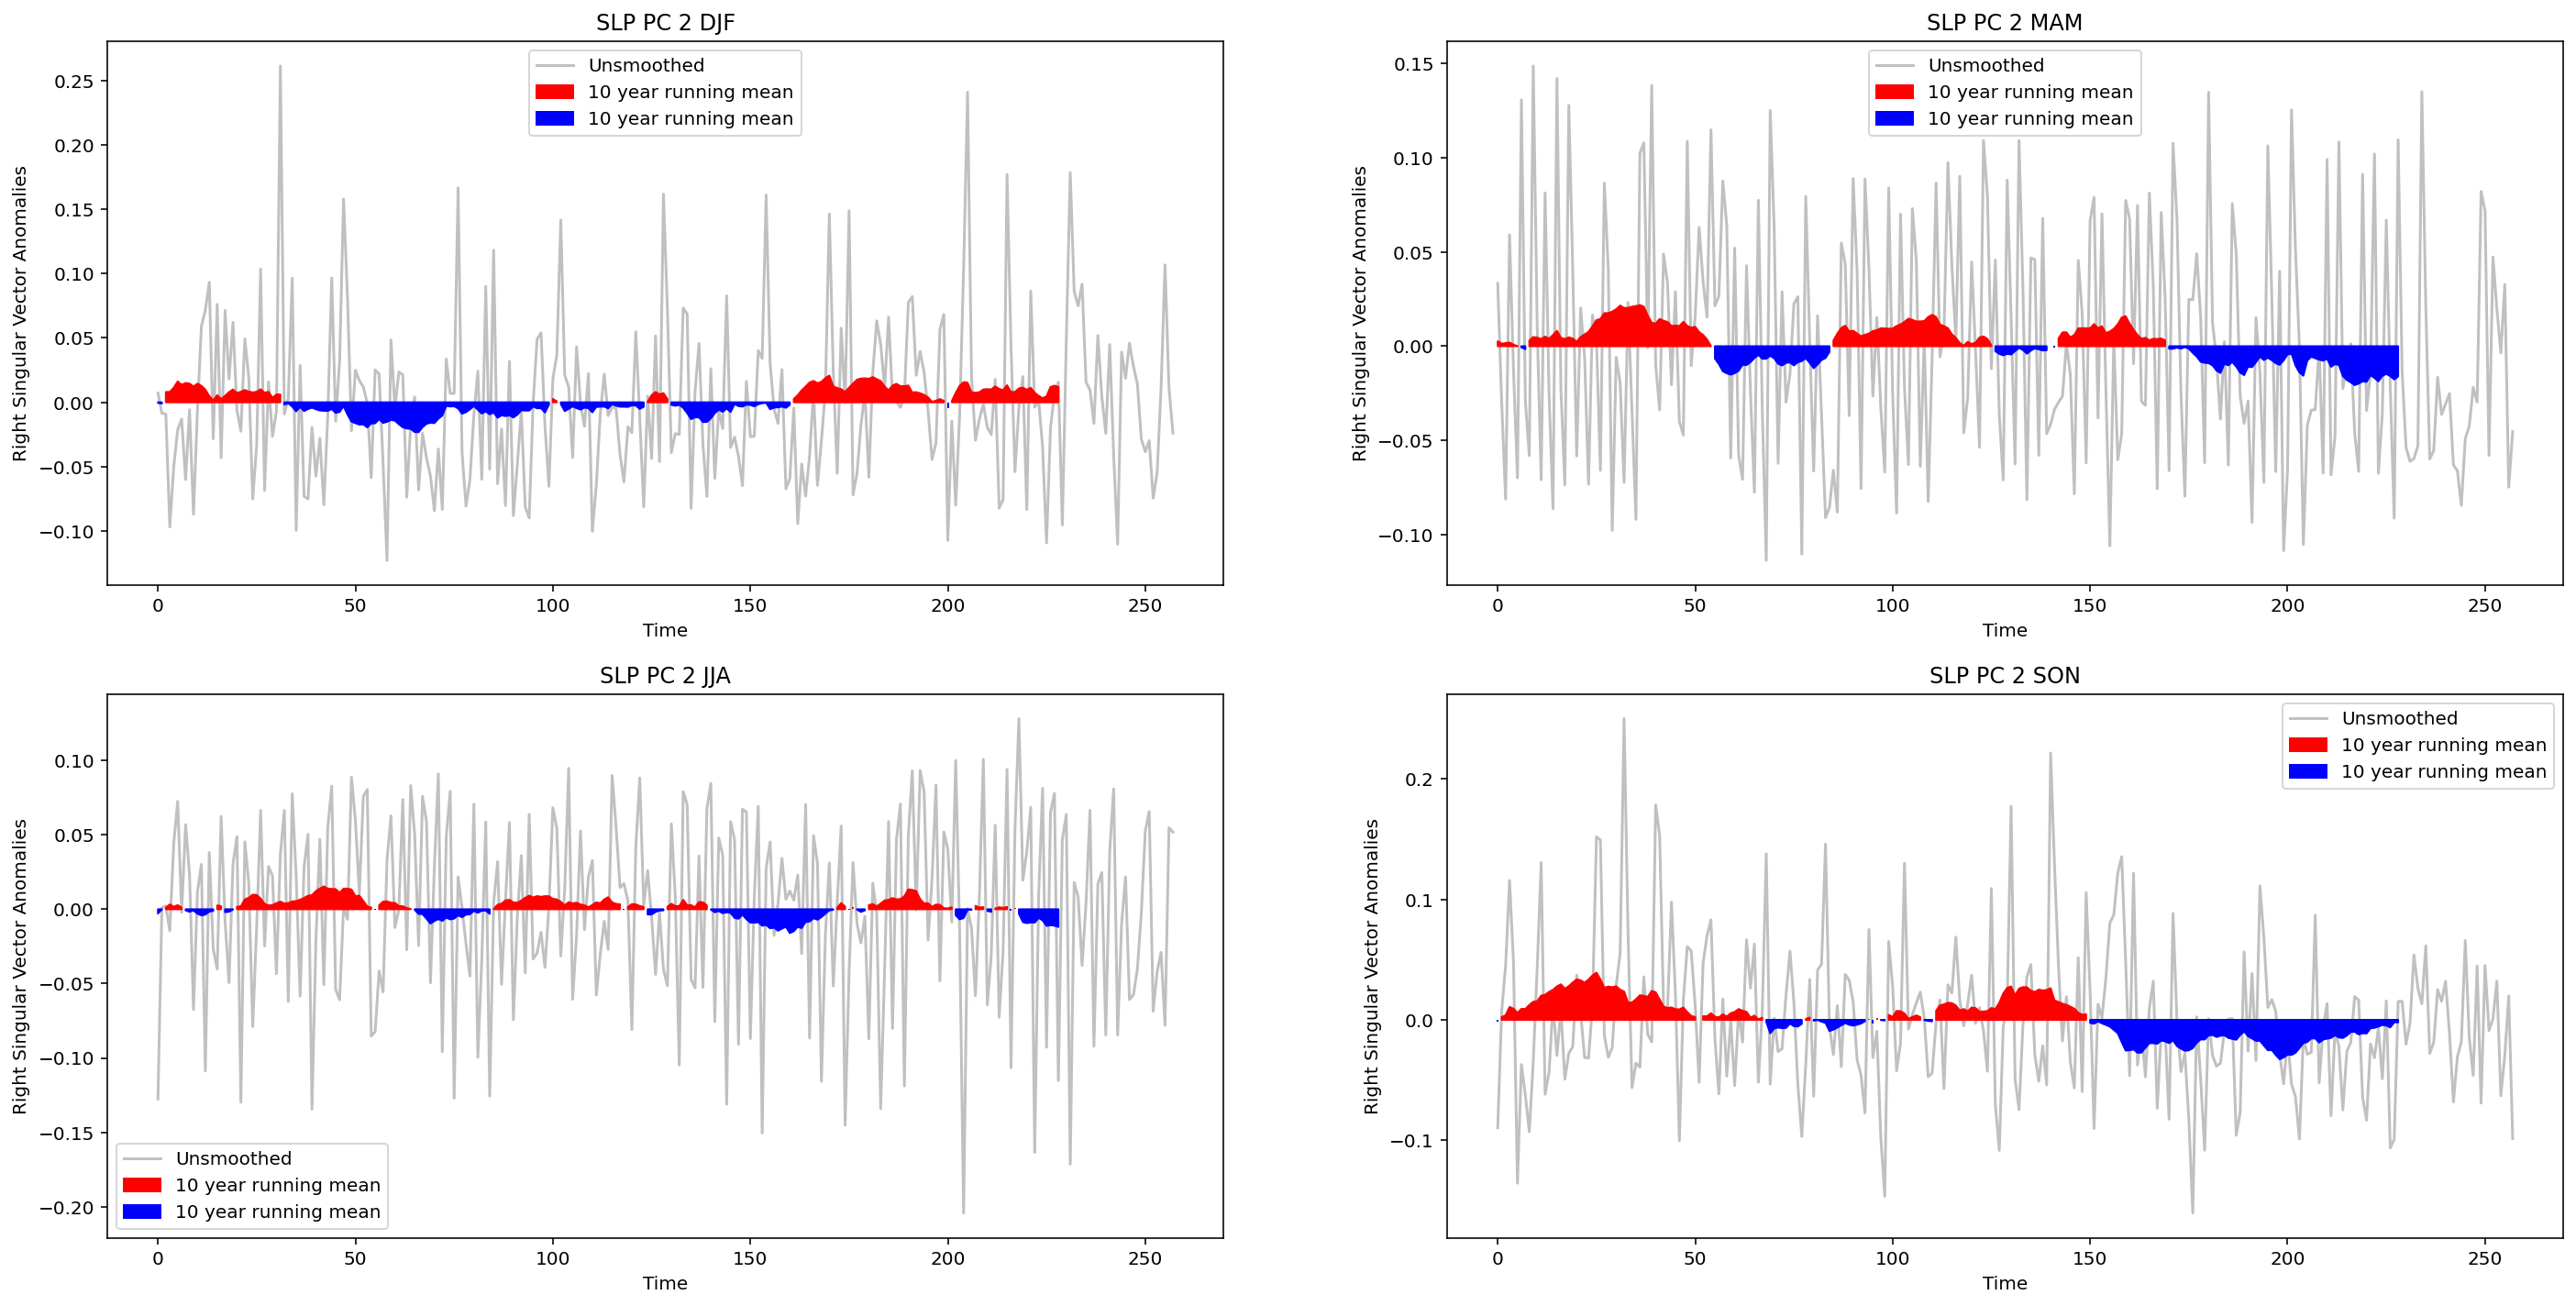

In [ ]:
for singVal in eigenpatterns:
  fig, axs = plt.subplots(2, 2, figsize=[24, 12])
  axlist = axs.flatten()
  for season in SEASONS:
    x = np.arange(0, 258)
    axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['anomalies'][season], where=eigenpatterns['singVal '+singVal[-1]]['anomalies'][season]>0, color='r')
    axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['anomalies'][season], where=eigenpatterns['singVal '+singVal[-1]]['anomalies'][season]<0, color='b')
    if int(singVal[-1])==0:
      axlist[SEASONS.index(season)].set_title('NAO Index (PC 1) '+season)
    else:
      axlist[SEASONS.index(season)].set_title('SLP PC '+str(int(singVal[-1])+1)+' '+season)
    axlist[SEASONS.index(season)].set_ylabel('Right Singular Vector Anomalies')
    axlist[SEASONS.index(season)].set_xlabel('Time')
  plt.show()
  fig, axs = plt.subplots(2, 2, figsize=[24, 12])
  axlist = axs.flatten()
  for season in SEASONS:
    x = np.arange(0, len(nao_smoothed))
    axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['smoothed'][season], where=eigenpatterns['singVal '+singVal[-1]]['smoothed'][season]>0, color='r', label='10 year running mean')
    axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['smoothed'][season], where=eigenpatterns['singVal '+singVal[-1]]['smoothed'][season]<0, color='b', label='10 year running mean')
    axlist[SEASONS.index(season)].plot(eigenpatterns['singVal '+singVal[-1]]['anomalies'][season], 'silver', zorder=0, label='Unsmoothed')
    # plt.plot(x)
    if int(singVal[-1])==0:
      axlist[SEASONS.index(season)].set_title('NAO Index (PC 1) '+season)
    else:
      axlist[SEASONS.index(season)].set_title('SLP PC '+str(int(singVal[-1])+1)+' '+season)
    axlist[SEASONS.index(season)].set_ylabel('Right Singular Vector Anomalies')
    axlist[SEASONS.index(season)].set_xlabel('Time')
    axlist[SEASONS.index(season)].legend()

## **Combining much of the above into a function that can be run in a loop:**

In [ ]:
def smoothplot():
  for member in range(len(psl_ssp585.zstore.values)): 
    print(member)
    global psl
    # Accessing the file, getting it to just the lats and lons I want:
    zstore = psl_ssp585.zstore.values[member]
    mapper = fsspec.get_mapper(zstore)
    ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Make decode_times=True to convert dates to datetime objects?? The problem is, Colab doesn't seem to like my installation of nc-time-axis. I could try a Jupyter Binder, or keep Googling to try to solve this.
    psl = ds.psl.sel(lat=slice(20,80))
    psl = psl.where((ds.lon >= 270) | (ds.lon <= 40), drop=True)
    lat = ds.lat.sel(lat=slice(20,80))
    lon = ds.lon.where((ds.lon >= 270) | (ds.lon <= 40), drop=True) # Not sure exactly what drop means, but I think it doesn't matter


    # Useful stackexchange post: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
    def is_djf(month):
      return (month>=12) | ((month>=1) & (month<=2))
    def is_mam(month):
      return (month>=3) & (month<=5)
    def is_jja(month):
      return (month>=6) & (month<=8)
    def is_son(month):
      return (month>=9) & (month<=11)
    psl_djf = psl.sel(time=is_djf(psl['time.month']))
    psl_mam = psl.sel(time=is_mam(psl['time.month']))
    psl_jja = psl.sel(time=is_jja(psl['time.month']))
    psl_son = psl.sel(time=is_son(psl['time.month']))


    psl_allseasons = {
        'DJF': psl_djf,
        'MAM': psl_mam,
        'JJA': psl_jja,
        'SON': psl_son
    }
    century_trends = {
        'DJF': {},
        'JJA': {},
        'MAM': {},
        'SON': {}
    }
    for key in psl_allseasons.keys():
      tlength = len(psl_allseasons[key].time) # The psl_WEIGHTED dictionary does not contain DataArray objects, so I can't just get the time from that.
      latlength = len(psl_allseasons[key].lat)
      lonlength = len(psl_allseasons[key].lon)
      psl2d = np.reshape(psl_allseasons[key].values, (tlength, latlength*lonlength)) # This is the only line in the for loop I changed when adding in the weighting
      psl2d = np.matrix.transpose(psl2d)
      Unow, snow, VTnow = LA.svd(psl2d, full_matrices=False)
      century_trends[key]['U'] = Unow
      century_trends[key]['s'] = snow
      century_trends[key]['VT'] = VTnow
    eigenpatterns = {}
    SEASONS = ['DJF', 'MAM', 'JJA', 'SON']
    # Moving average code from https://stackoverflow.com/questions/14313510/how-to-calculate-rolling-moving-average-using-numpy-scipy
    def moving_average(x, w):
        return np.convolve(x, np.ones(w), 'valid') / w
    eigenpatterns['singVal 0']={
        'anomalies': {},
        'smoothed': {}
    }
    for season in SEASONS:
      eigenpatterns['singVal 0']['anomalies'][season] = century_trends[season]['VT'][0]-np.mean(century_trends[season]['VT'][0])
      nao_smoothed = moving_average(eigenpatterns['singVal 0']['anomalies'][season], 30) # Doing the moving average for 30 points because each season is 3 months per year - so this is a 10 year running mean
      eigenpatterns['singVal 0']['smoothed'][season] = nao_smoothed

    #   axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['normalized'][season], where=eigenpatterns['singVal '+singVal[-1]]['normalized'][season]>0, color='r')
    #   axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal '+singVal[-1]]['normalized'][season], where=eigenpatterns['singVal '+singVal[-1]]['normalized'][season]<0, color='b')
    #   if int(singVal[-1])==0:
    #     axlist[SEASONS.index(season)].set_title('NAO Index (PC 1) '+season)
    #   else:
    #     axlist[SEASONS.index(season)].set_title('SLP PC '+str(int(singVal[-1])+1)+' '+season)
    #   axlist[SEASONS.index(season)].set_ylabel('Right Singular Vector Normalized Anomalies')
    #   axlist[SEASONS.index(season)].set_xlabel('Time')
    #   # axlist[SEASONS.index(season)].set_xticks(np.arange(495), ([j for j in psl_allseasons[season].time]))
    # plt.show()
    fig, axs = plt.subplots(2, 2, figsize=[24, 12])
    axlist = axs.flatten()
    for season in SEASONS:
      # x = np.arange(0, 495)
      x = np.arange(0, len(nao_smoothed))
      axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal 0']['smoothed'][season], where=eigenpatterns['singVal 0']['smoothed'][season]>0, color='r', label='10 year running mean')
      axlist[SEASONS.index(season)].fill_between(x, 0, eigenpatterns['singVal 0']['smoothed'][season], where=eigenpatterns['singVal 0']['smoothed'][season]<0, color='b', label='10 year running mean')
      axlist[SEASONS.index(season)].plot(eigenpatterns['singVal 0']['anomalies'][season], 'silver', zorder=0, label='Unsmoothed')
      # plt.plot(x)
      axlist[SEASONS.index(season)].set_title('NAO Index (PC 1) '+season)
      axlist[SEASONS.index(season)].set_ylabel('Right Singular Vector Anomalies')
      axlist[SEASONS.index(season)].set_xlabel('Time')
      axlist[SEASONS.index(season)].legend()
    plt.show()
# smoothplot()

## **Running the above function for a few different models:**

## **SSP5-8.5:**

The following code throws an error at the end because the last model, MCM-UA-1-0, has its dimensions named a bit differently than most (latitude instead of lat, longitude instead of lon). Doesn't matter for now but eventually I'll need to fix it



In [ ]:
test = df.query("variable_id == 'psl' & experiment_id == 'ssp585' & table_id == 'Amon'")
usource = []
for m in test.source_id:
  if m not in usource:
    usource.append(m)

for source in usource:
  print(source)
  abc = "variable_id == 'psl' & experiment_id == 'ssp585' & table_id == 'Amon' & source_id == "+"'"+source+"'"
  psl_ssp585 = df.query(abc)
  print('length: ', len(psl_ssp585.zstore.values))
  smoothplot()

## **SSP4-3.4**:

In [ ]:
test = df.query("variable_id == 'psl' & experiment_id == 'ssp434' & table_id == 'Amon'")
usource = []
for m in test.source_id:
  if m not in usource:
    usource.append(m)
print(usource)
for source in usource:
  print(source)
  abc = "variable_id == 'psl' & experiment_id == 'ssp434' & table_id == 'Amon' & source_id == "+"'"+source+"'"
  psl_ssp585 = df.query(abc)
  print('length: ', len(psl_ssp585.zstore.values))
  smoothplot()
print(usource)
print(psl.time)
uexp = []
for m in df.experiment_id:
  if m not in uexp:
    uexp.append(m)
for i in uexp:
  print(i)
test

## **SSP5-3.4-over:**

In [ ]:
test = df.query("variable_id == 'psl' & experiment_id == 'ssp534-over' & table_id == 'Amon'")
usource = []
for m in test.source_id:
  if m not in usource:
    usource.append(m)

for source in usource:
  print(source)
  abc = "variable_id == 'psl' & experiment_id == 'ssp534-over' & table_id == 'Amon' & source_id == "+"'"+source+"'"
  psl_ssp585 = df.query(abc)
  print('length: ', len(psl_ssp585.zstore.values))
  smoothplot()
# uexp = []
# for m in df.experiment_id:
#   if m not in uexp:
#     uexp.append(m)
# print(uexp)

## **1pctCO2-cdr:**

In [ ]:
test = df.query("variable_id == 'psl' & experiment_id == '1pctCO2-cdr' & table_id == 'Amon'")
usource = []
for m in test.source_id:
  if m not in usource:
    usource.append(m)
print(usource)
for source in usource:
  print(source)
  abc = "variable_id == 'psl' & experiment_id == '1pctCO2-cdr' & table_id == 'Amon' & source_id == "+"'"+source+"'"
  psl_ssp585 = df.query(abc)
  print('length: ', len(psl_ssp585.zstore.values))
  smoothplot()
print(usource)
# uexp = []
# for m in df.experiment_id:
#   if m not in uexp:
#     uexp.append(m)
# for i in uexp:
#   print(i)
print(psl.time)

## **ESM-pi-CDR-pulse:**

In [ ]:
test = df.query("variable_id == 'psl' & experiment_id == 'esm-pi-cdr-pulse' & table_id == 'Amon'")
usource = []
for m in test.source_id:
  if m not in usource:
    usource.append(m)
print(usource)
for source in usource:
  print(source)
  abc = "variable_id == 'psl' & experiment_id == 'esm-pi-cdr-pulse' & table_id == 'Amon' & source_id == "+"'"+source+"'"
  psl_ssp585 = df.query(abc)
  print('length: ', len(psl_ssp585.zstore.values))
  smoothplot()
print(usource)
print(psl.time)
# uexp = []
# for m in df.experiment_id:
#   if m not in uexp:
#     uexp.append(m)
# for i in uexp:
#   print(i)

## **Plotting PC1 vs PC2 phase space:**




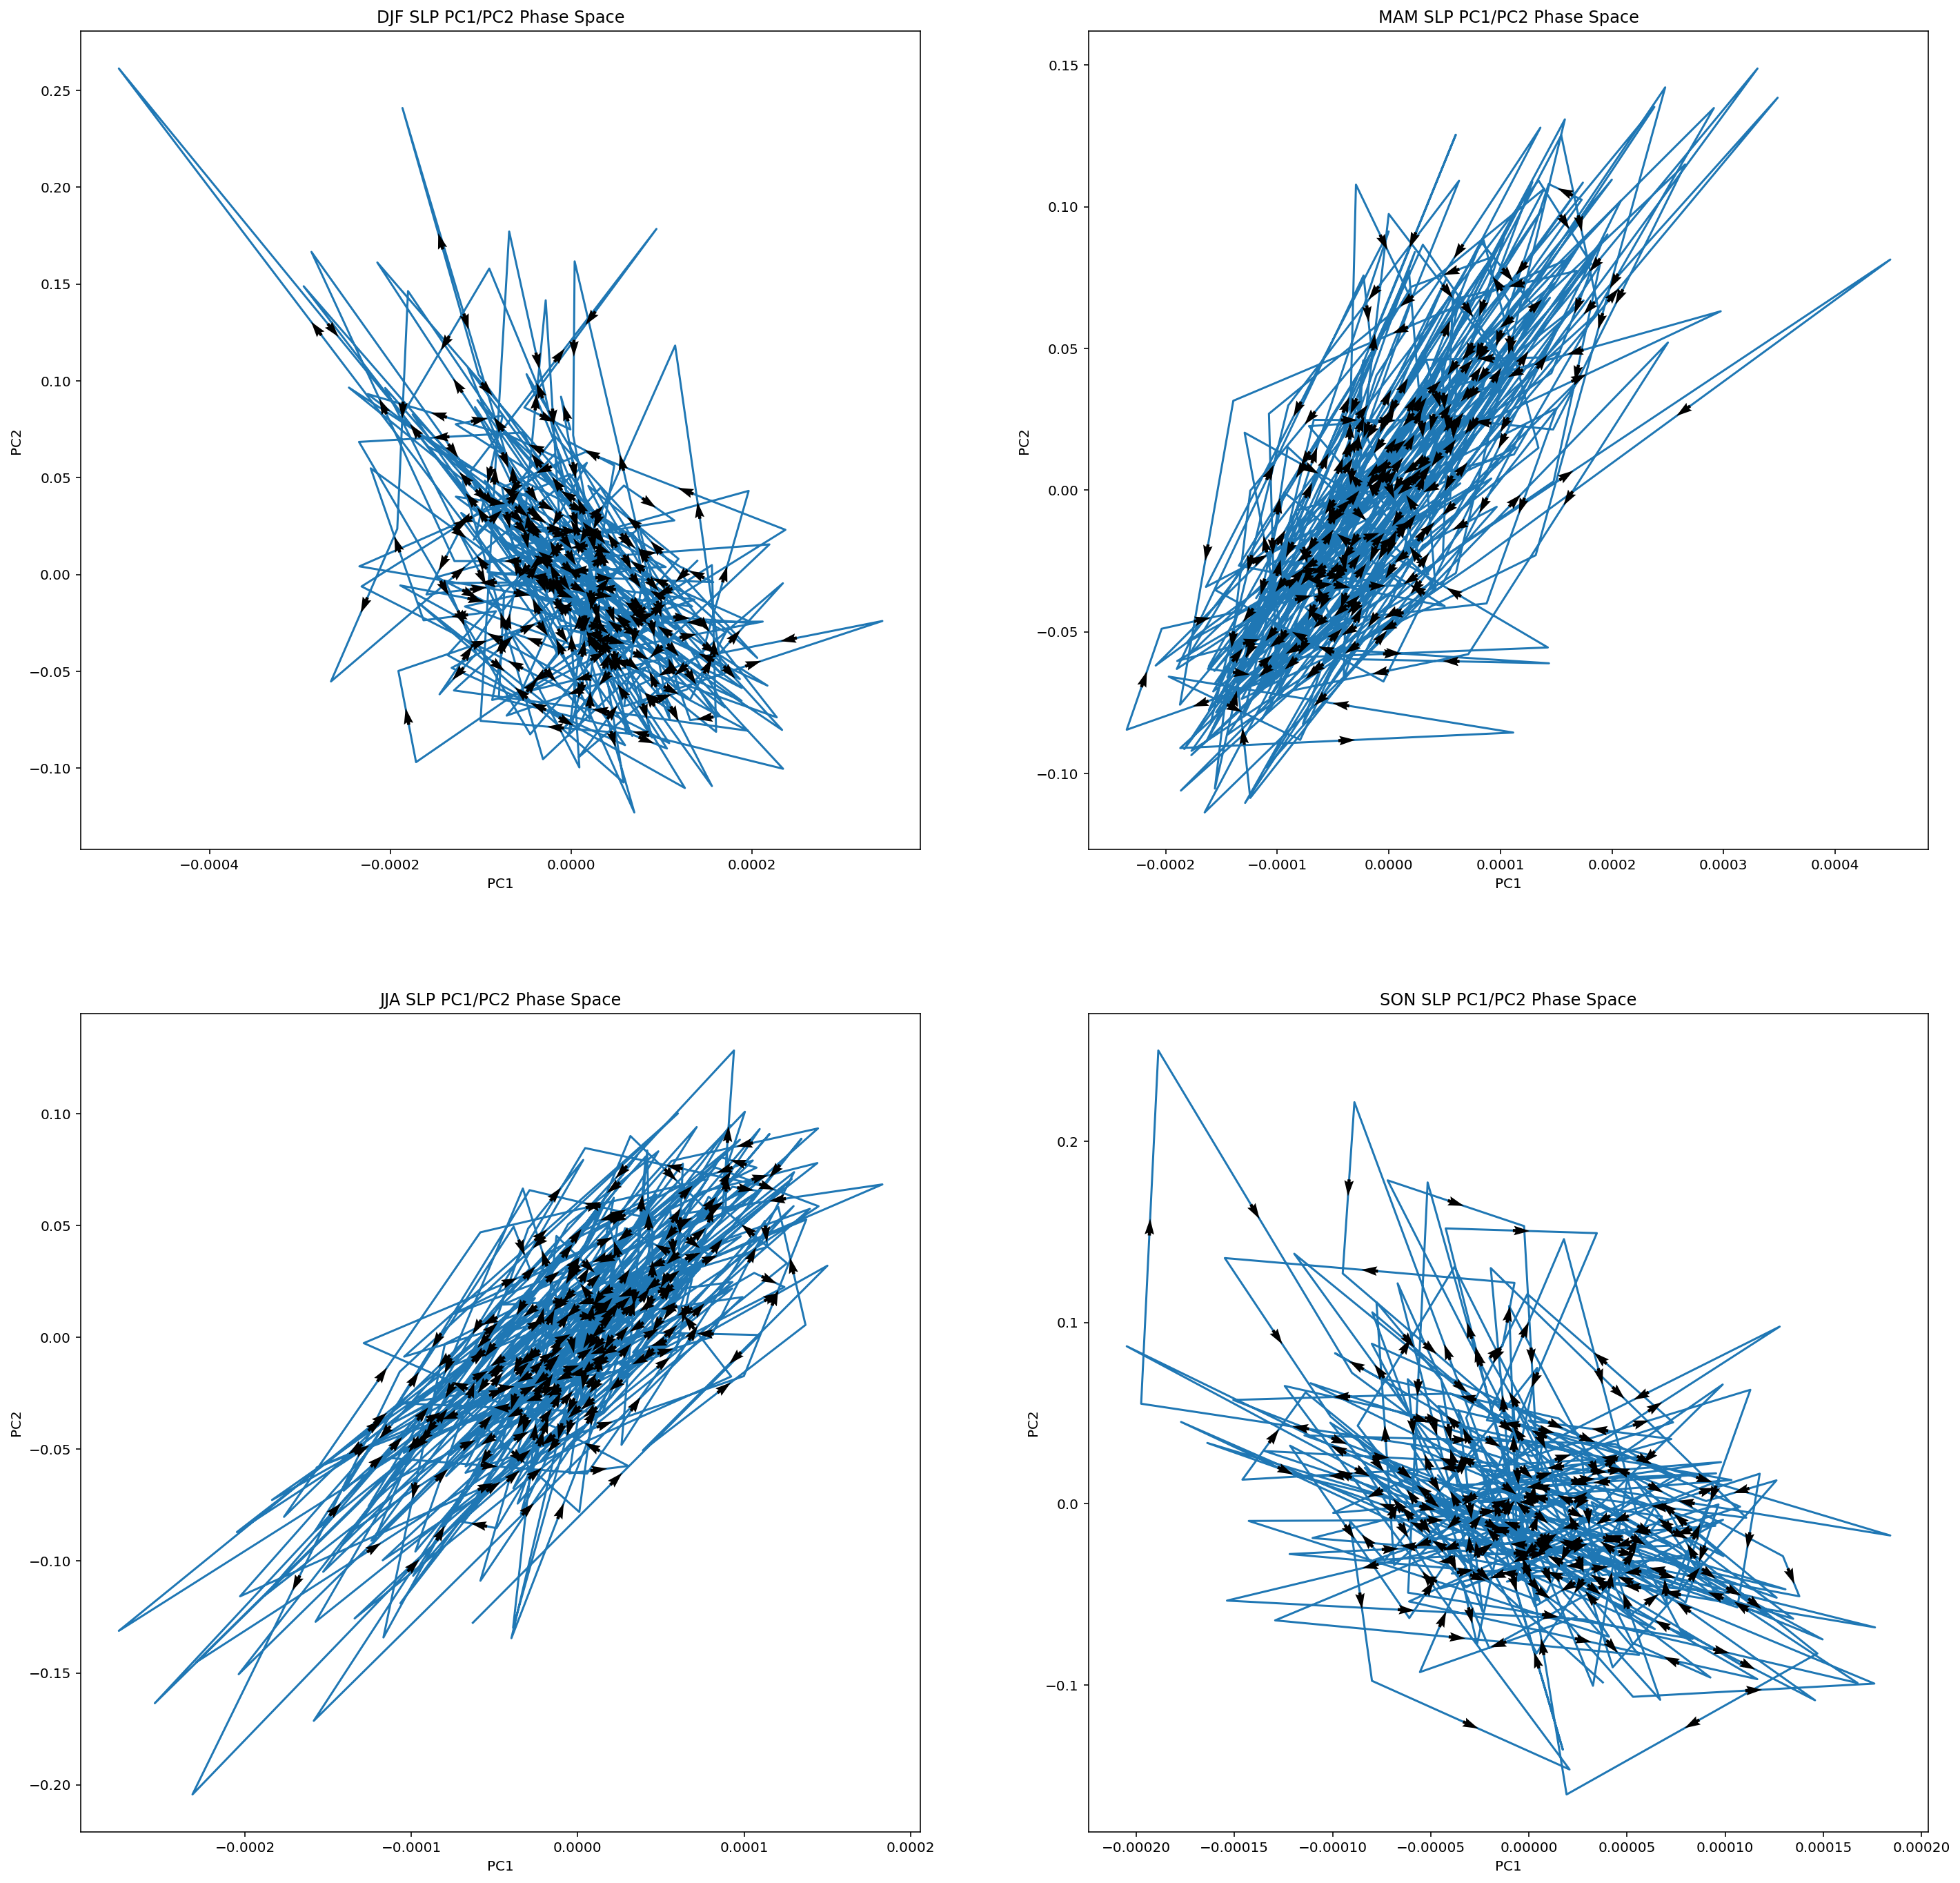

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=[24, 24])
axlist = axs.flatten()
for season in SEASONS:
  #this link helped me figure out how to put the arrows on the plot: https://stackoverflow.com/questions/58342419/show-direction-arrows-in-a-scatterplot
  x_difference = np.diff(eigenpatterns['singVal 0']['anomalies'][season])
  x_position = eigenpatterns['singVal 0']['anomalies'][season][:-1] + x_difference/2
  y_difference = np.diff(eigenpatterns['singVal 1']['anomalies'][season])
  y_position = eigenpatterns['singVal 1']['anomalies'][season][:-1] + y_difference/2
  norm = np.sqrt(x_difference**2+y_difference**2)
  axlist[SEASONS.index(season)].plot(eigenpatterns['singVal 0']['anomalies'][season], eigenpatterns['singVal 1']['anomalies'][season], zorder=0)
  axlist[SEASONS.index(season)].quiver(x_position, y_position, x_difference/norm, y_difference/norm, angles='xy', pivot='mid', scale=50)
  axlist[SEASONS.index(season)].set_xlabel('PC1')
  axlist[SEASONS.index(season)].set_ylabel('PC2')
  axlist[SEASONS.index(season)].set_title(season+' SLP PC1/PC2 Phase Space')

## Probability Angular Momentum Analysis

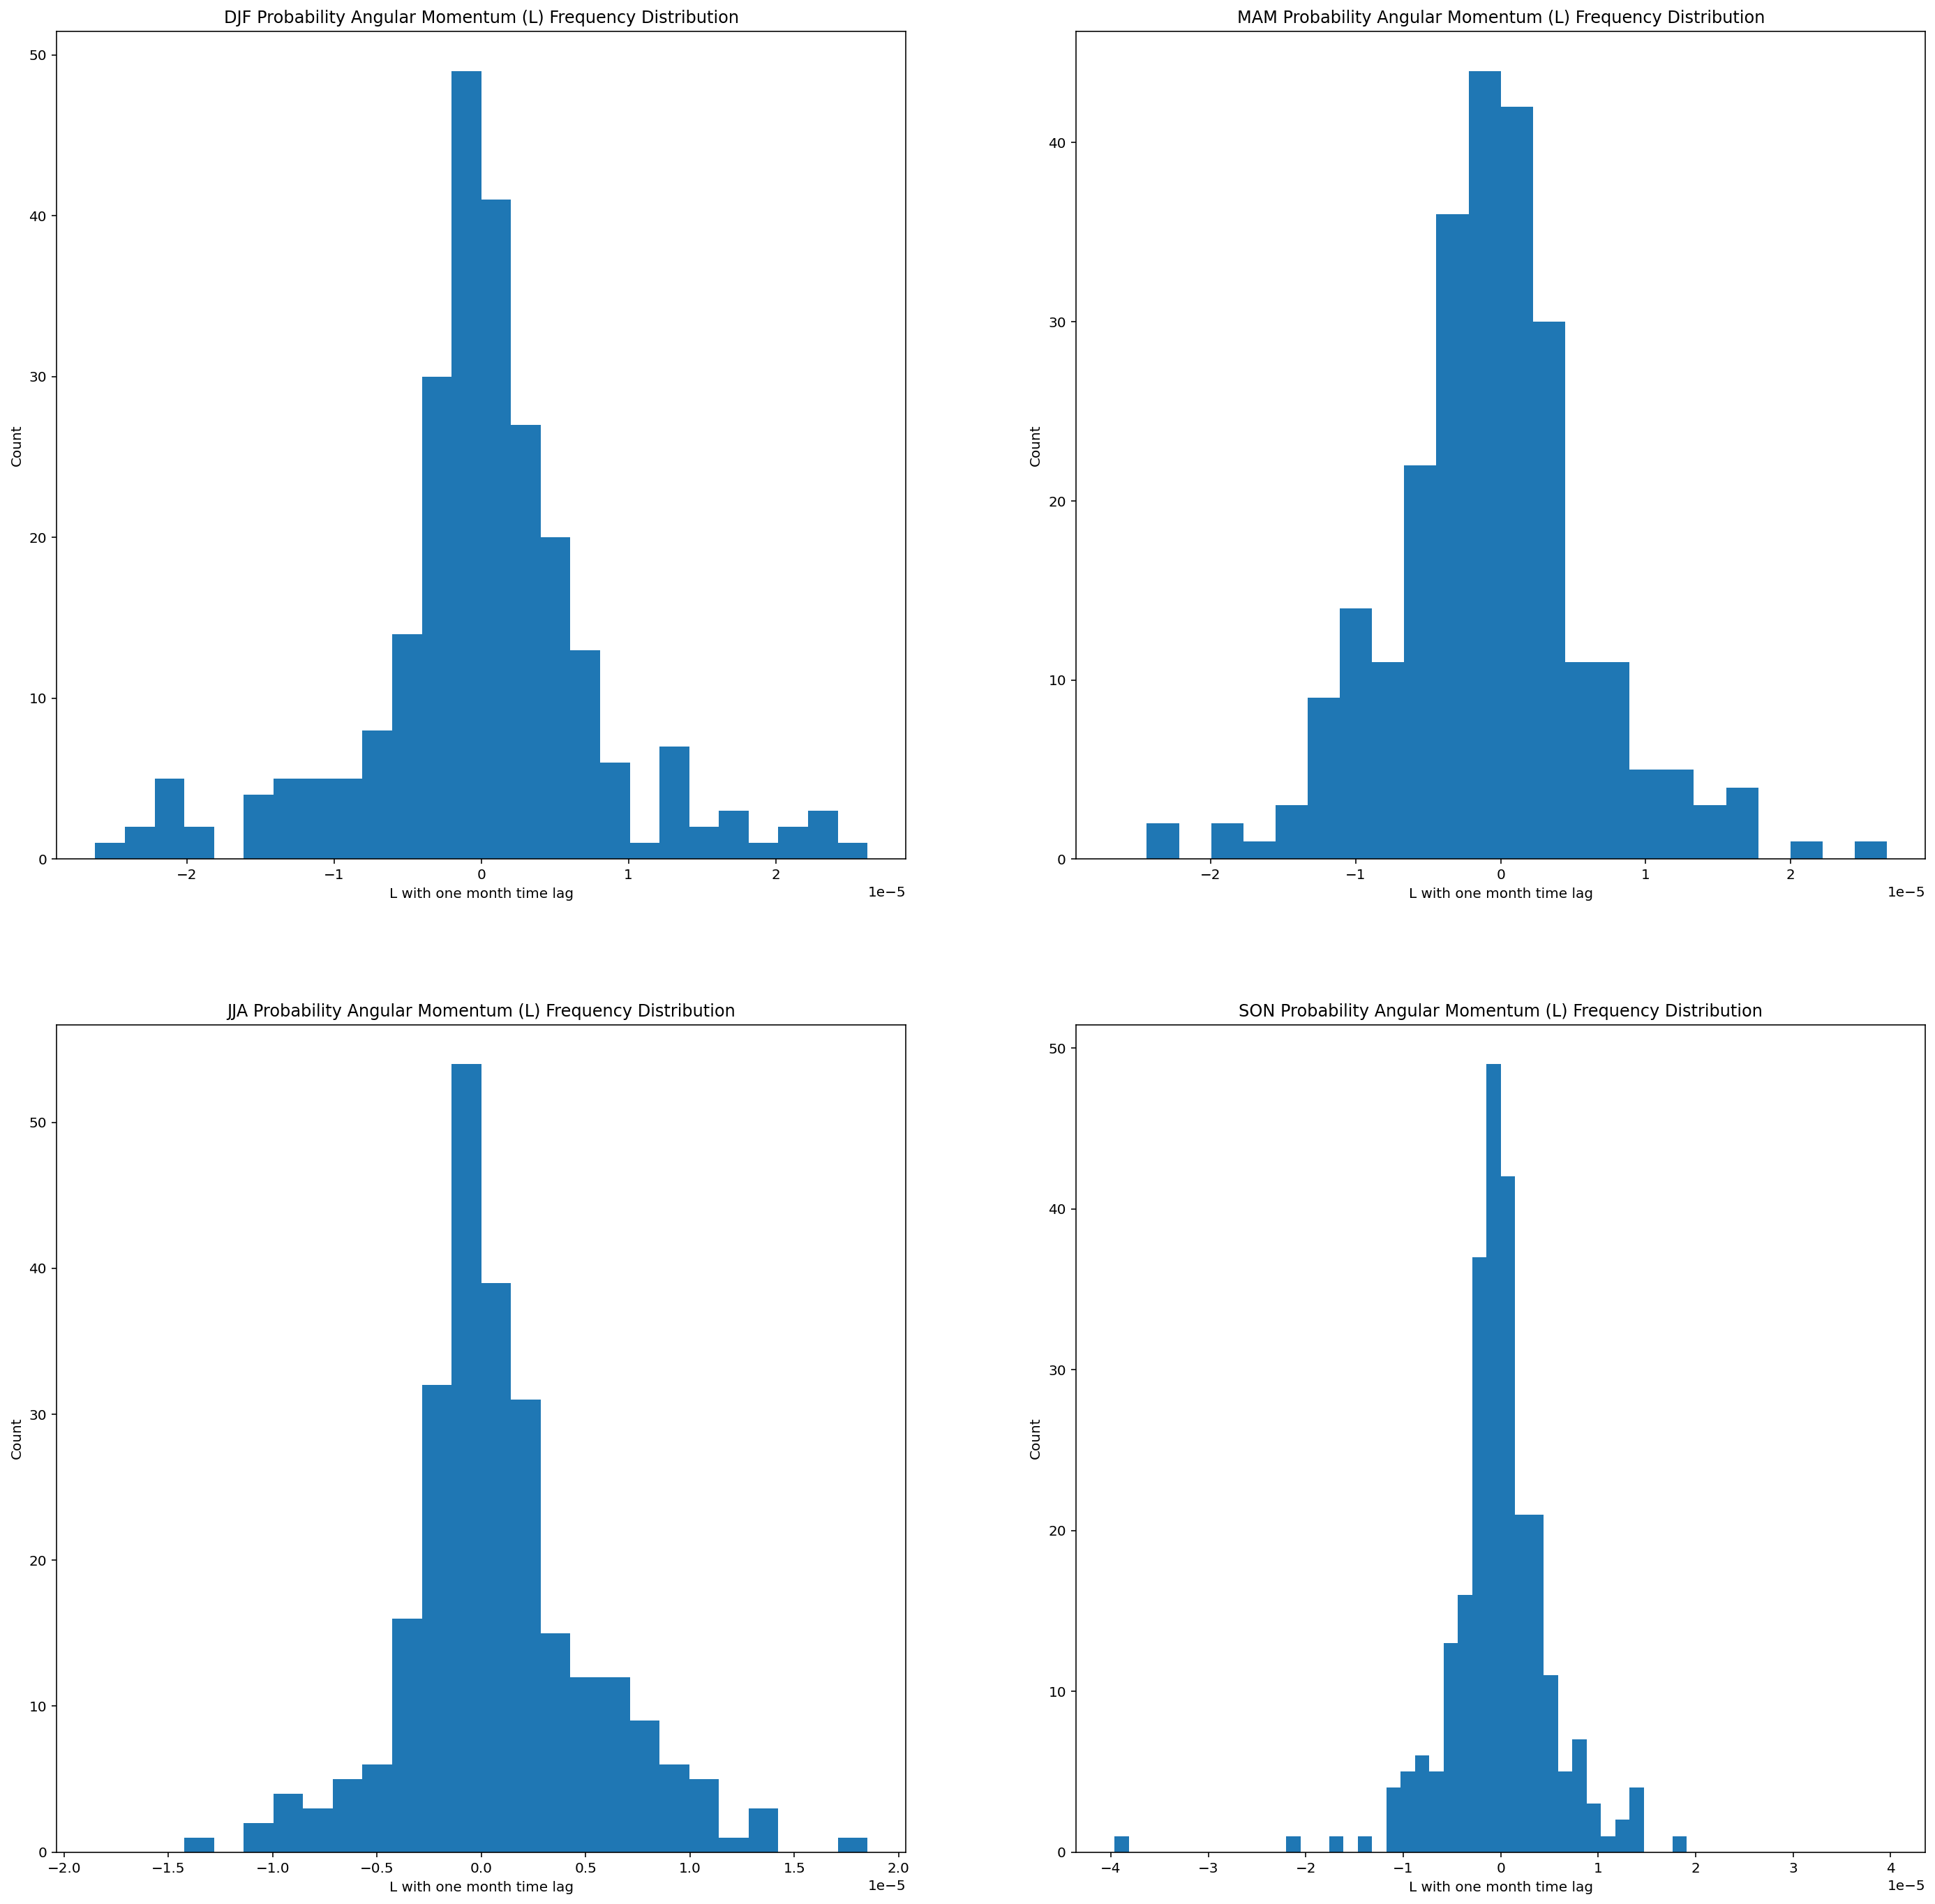

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=[24, 24])
axlist = axs.flatten()
for season in SEASONS:
  x1 = np.array(eigenpatterns['singVal 0']['anomalies'][season])
  x2 = np.array(eigenpatterns['singVal 1']['anomalies'][season])
  T = 1

  # The following lines were originally written to try to do Arin's version of the Freedman-Diaconis rule, which involves the second part of equation 3.23 in his thesis.
  # However, the wikipedia entry on this rule says I can use the sample size for n under the cube root in the denominator, which is much simpler than Arin's method.
  # https://en.wikipedia.org/wiki/Freedman–Diaconis_rule
  # So for now I'll follow the Wikipedia version, potentially changing my strategy later. The following code should be kept just in case I end up wanting to use it.
  # I need to compute the lagged cross-correlation between x1 and x2. 
  # This will be based on equations 3.2 and 3.9 in Arin Nelson's PhD thesis.
  # It will be used to compute the bin widths for the histogram following equation 3.23 in Arin's thesis.
  # cov_sum = 0
  # for i in range(len(x1)-T): # Equation 3.9 in Arin's thesis. This for loop does a summation
  #   cov_sum+=x1[i]+x2[i+T]
  # x12_stacked = np.stack((x1, x2), axis=0) # I'm creating one array whose rows are x1 and x2 in order to use np.cov to get the covariance matrix
  # covMatrix = np.cov(x12_stacked)
  # x12_covariance = covMatrix[0, 1] # The entries outside the diagonal are the covariances between the variables. See: https://machinelearningmastery.com/how-to-use-correlation-to-understand-the-relationship-between-variables/
  # # https://corporatefinanceinstitute.com/resources/knowledge/finance/covariance/
  # # I think numpy is using sample covariance...and I think I can trust that to be the correct formula
  # C_x1_x2 = cov_sum/(x12_covariance*(len(x1)-1)) # The lagged cross-correlation between x1 and x2 (this is NOT symmetric, it's different if it's between x2 and x1). This completes the use of equation 3.9 in Arin's thesis.
  # # Different way to sum:
  # # C_x1_x2 = np.sum([x1[i]+x2[i+T] for i in range(len(x1)-T)])/(x12_covariance*(len(x1)-1))

  L = np.zeros((len(x1)-T)) # This will be the Probability Angular Momentum array
  for i in range(len(L)):
    L[i]=(x1[i]*x2[i+T]-x2[i]*x1[i+T])/T
  # I must make a histogram of L, with the bins determined as in Arin Nelson's PhD thesis, using the Freedman-Diaconis rule (see p. 47-48 of his thesis)
  iqr = stats.iqr(L) # Defaults to linear interpolation, I'm not sure whether this is ideal
  n = len(L)
  w = 2*(iqr/np.cbrt(n))
  Lmax = max(L)
  Lmin = min(L)
  binNum = int(np.ceil(max([np.abs(Lmax/w), np.abs(Lmin/w)])))
  binNum
  binArrayHalf = np.array([i*w for i in range(binNum+1)])
  binArrayMinus = binArrayHalf[1:]*-1
  allBins = np.concatenate((np.flip(binArrayMinus), binArrayHalf))
  axlist[SEASONS.index(season)].hist(L, bins=allBins)
  axlist[SEASONS.index(season)].set_title(season+' Probability Angular Momentum (L) Frequency Distribution')
  axlist[SEASONS.index(season)].set_ylabel('Count')
  axlist[SEASONS.index(season)].set_xlabel('L with one month time lag')